# Курсовой проект: Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

### Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели предсказать цены для квартир из файла test.csv.

#### Целевая переменная:
Price

#### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).

2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.

#### Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#### Рекомендации для файла с кодом (ipynb):

1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Метрики качества
from sklearn.metrics import mean_squared_error , r2_score

In [4]:
# Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [5]:
# настройка, чтобы можно было просматривать все столбцы датафрейма
pd.options.display.max_columns = 100

In [6]:
# убирает ненужные предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

### Функции для построения графиков

In [7]:
def graph_log(df_name, name, bins_):
    plt.figure(figsize = (16, 8))
    plt.yscale(value='log')
    df_name[name].hist(bins = bins_)
    plt.ylabel('Count')
    plt.xlabel(name)
    
    plt.title(name)
    plt.show()
    return

In [8]:
def graph(df_name, name, bins_):
    plt.figure(figsize = (16, 8))
    df_name[name].hist(bins = bins_)
    plt.ylabel('Count')
    plt.xlabel(name)
    plt.title(name)
    plt.show()
    return

### Пути к директориям и файлам

In [9]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
TEST_DATASET_EXT_PATH = 'EremenkoPA_predictions.csv'

### Загрузка данных

#### Тренировочный сет

In [10]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


#### Описание датасета

```
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры 
```

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [12]:
# поменяем типы 2х полей c идентификационными номерами на строковые
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [14]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [15]:
train_df.shape

(10000, 20)

#### Тестовый сет

In [16]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [17]:
test_df.shape

(5000, 19)

### Исследовательский анализ данных (EDA)

#### Целевая переменная

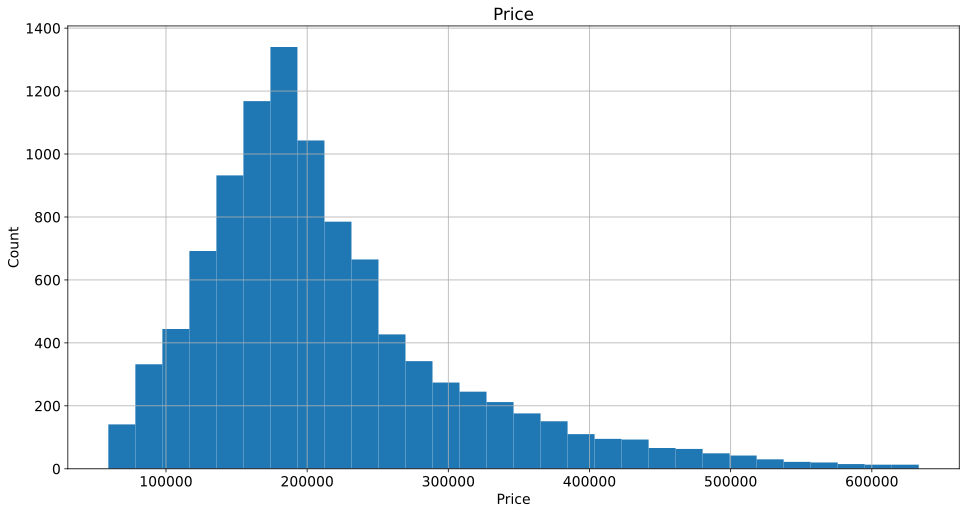

In [18]:
graph(train_df, 'Price', 30)


In [19]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = round(train_df['Price'].median(), 2)

target_mean, target_median

(214138.86, 192269.64)

Целевая переменная распределена равномерно, выбросов не видно

Медианная цена - 192269$,

Средняя цена в датасете - 214138$

#### Количественые переменные

In [20]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [21]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [22]:
train_df['DistrictId'].value_counts()

DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: count, Length: 205, dtype: int64

In [23]:
train_df['Ecology_2'].value_counts()

Ecology_2
B    9903
A      97
Name: count, dtype: int64

In [24]:
train_df['Ecology_3'].value_counts()

Ecology_3
B    9725
A     275
Name: count, dtype: int64

In [25]:
train_df['Shops_2'].value_counts()

Shops_2
B    9175
A     825
Name: count, dtype: int64

### Обработка выбросов

Варианты действий: 
Игнорировать и выбросить эти данные (только на трейне)
Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
Делать/не делать дополнительную фичу
Ничего не делать

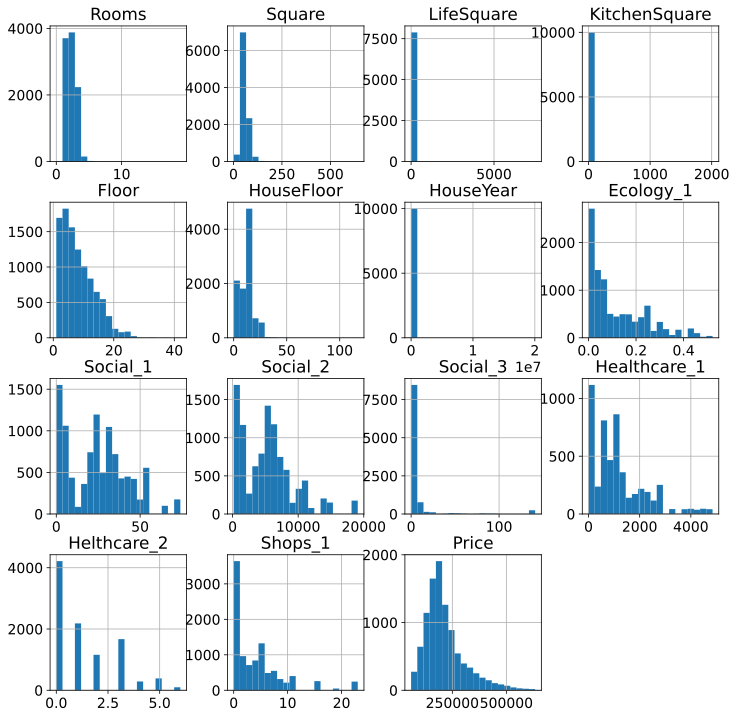

In [26]:
train_df.hist(bins=20, figsize=(12, 12))
plt.show()

Видно, что в признаках Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear скорее всего присутствуют выбросы

Изучим их детальней

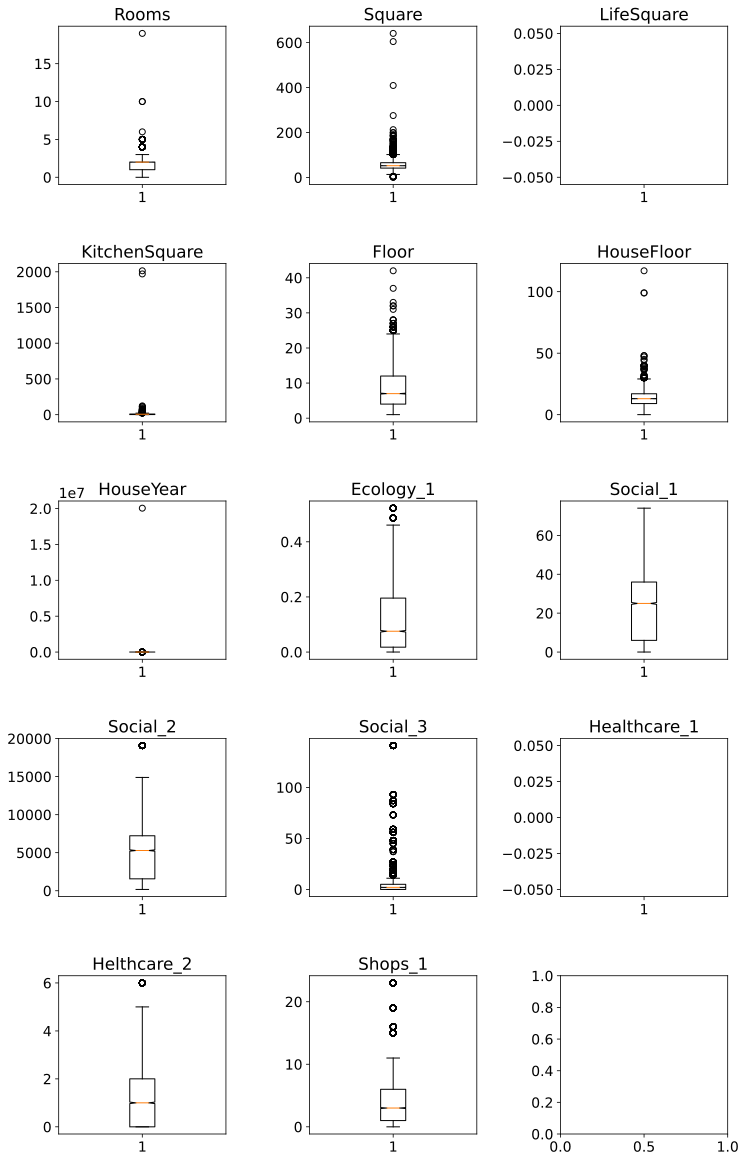

In [27]:
fig, ax = plt.subplots(nrows=5, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15  = ax.flatten()

ax1.boxplot(train_df['Rooms'], ['Rooms'])
ax1.set_title('Rooms')

ax2.boxplot(train_df['Square'], ['Square'])
ax2.set_title('Square')

ax3.boxplot(train_df['LifeSquare'], ['LifeSquare'])
ax3.set_title('LifeSquare')

ax4.boxplot(train_df['KitchenSquare'], ['KitchenSquare'])
ax4.set_title('KitchenSquare')

ax5.boxplot(train_df['Floor'], ['Floor'])
ax5.set_title('Floor')

ax6.boxplot(train_df['HouseFloor'], ['HouseFloor'])
ax6.set_title('HouseFloor')

ax7.boxplot(train_df['HouseYear'], ['HouseYear'])
ax7.set_title('HouseYear')

ax8.boxplot(train_df['Ecology_1'], ['Ecology_1'])
ax8.set_title('Ecology_1')

ax9.boxplot(train_df['Social_1'], ['Social_1'])
ax9.set_title('Social_1')

ax10.boxplot(train_df['Social_2'], ['Social_2'])
ax10.set_title('Social_2')

ax11.boxplot(train_df['Social_3'], ['Social_3'])
ax11.set_title('Social_3')

ax12.boxplot(train_df['Healthcare_1'], ['Healthcare_1'])
ax12.set_title('Healthcare_1')

ax13.boxplot(train_df['Helthcare_2'], ['Helthcare_2'])
ax13.set_title('Helthcare_2')

ax14.boxplot(train_df['Shops_1'], ['Shops_1'])
ax14.set_title('Shops_1')


fig.set_size_inches(12, 20)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

#### Признак Rooms

In [28]:
train_df['Rooms'].value_counts()

Rooms
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: count, dtype: int64

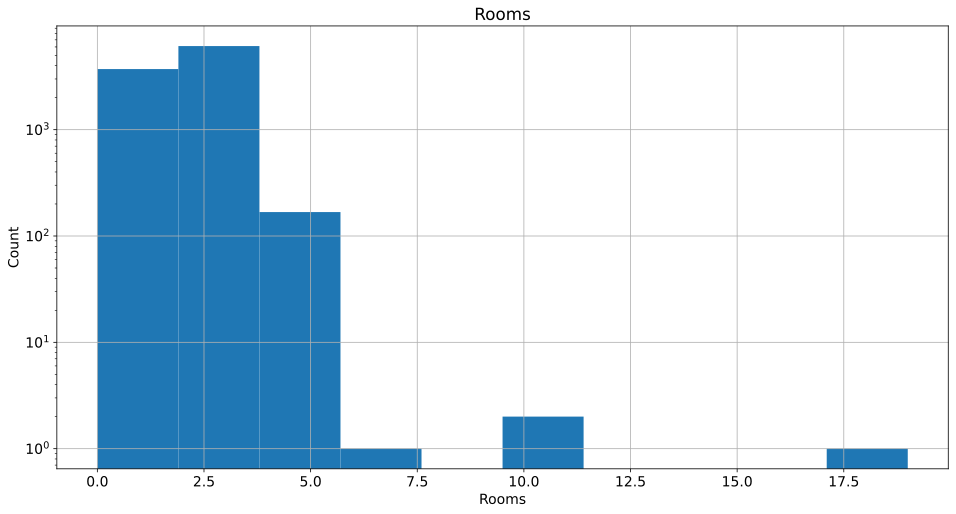

In [29]:
graph_log(train_df, 'Rooms', 10)

In [30]:
# выведем все наблюдения с количеством комнат более 5 и менее 1
train_df.loc[(train_df['Rooms'] <= 0) | (train_df['Rooms'] > 5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646


In [31]:
# Создаем вспомогательный столбец с признаком выброса
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] <= 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0


In [32]:
train_df['Rooms_outlier'].value_counts()

Rooms_outlier
0    9988
1      12
Name: count, dtype: int64

In [33]:
train_df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [34]:
train_df['Rooms'].mean()

1.8905

In [35]:
train_df['Rooms'].value_counts(bins=6)

Rooms
(-0.02, 3.167]      9828
(3.167, 6.333]       169
(9.5, 12.667]          2
(15.833, 19.0]         1
(6.333, 9.5]           0
(12.667, 15.833]       0
Name: count, dtype: int64

In [36]:
train_df['Rooms'].value_counts()

Rooms
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: count, dtype: int64

Логично предположить, что количество комнат зависит от площади дома

**Как скорректировать ['Rooms'] == 0 ?**

In [37]:
train_df[(train_df['Rooms'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389,1
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,1
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788,1
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463,1
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112,1
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,1
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007,1


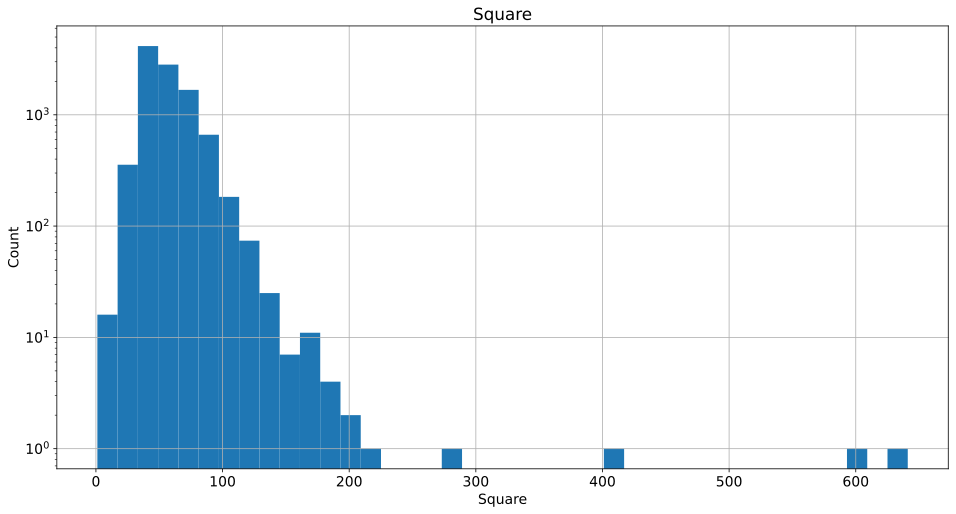

In [38]:
graph_log(train_df, 'Square', 40)

Возьмем объекты с площадью более 200 кв.м и выведем среднее количество комнат для них

In [39]:
train_df[(train_df['Square'] > 200) & (train_df['Rooms'] != 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666,0
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,0
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,0
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,0
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016,0


In [40]:
round(train_df.loc[(train_df['Square'] > 200) & (train_df['Rooms'] != 0), 'Rooms'].mean())

3

Присвоим среднее количество комнат 3 для площади больше 200

In [41]:
train_df.loc[(train_df['Square'] > 200) & (train_df['Rooms'] <= 0), 'Rooms'] = round(train_df.loc[(train_df['Square'] > 200) & (train_df['Rooms'] != 0), 'Rooms'].mean())

In [42]:
train_df[train_df['Id'] == '7917']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
1981,7917,27,3.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,1


Возьмем объекты с площадью менее 55 кв.м и выведем среднее количество комнат для них

In [43]:
train_df[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 55)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788,1
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463,1
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,1


In [44]:
round(train_df.loc[(train_df['Square'] <= 55), 'Rooms'].mean())

1

Присвоим среднее количество комнат 3 для площади больше 200

In [45]:
train_df.loc[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 55), 'Rooms'] = round(train_df.loc[(train_df['Square'] <= 55), 'Rooms'].mean())

In [46]:
train_df[train_df['Id'] == '3159']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
6149,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,1


Смотрим, какие еще объекты остались с нулевым количеством комнат

In [47]:
train_df[(train_df['Rooms'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389,1
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112,1
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007,1


In [48]:
round(train_df.loc[(train_df['Square'] > 55) & (train_df['Square'] <= 100), 'Rooms'].mean())

2

Присвоим среднее количество комнат 2 для площади от 55 до 100

In [49]:
train_df.loc[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 100), 'Rooms'] = round(train_df.loc[(train_df['Square'] > 55) & (train_df['Square'] <= 100), 'Rooms'].mean()) 

In [50]:
train_df[(train_df['Rooms'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389,1


Присвоим среднее количество комнат 3 для оставшегося объекта площадью более 100 и менее 155

In [51]:
train_df.loc[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 150), 'Rooms'] = round(train_df.loc[(train_df['Square'] > 100) & (train_df['Square'] <= 150), 'Rooms'].mean()) 

In [52]:
train_df[(train_df['Rooms'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier


Объекты с нулевым количеством комнат теперь отсутствуют, 
Но остались объекты с количеством комнат более 6

In [53]:
train_df[train_df['Rooms'] >= 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792,1
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704,1
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416,1
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863,1


Если посмотреть на эти выбросы, то можно сделать вывод, что присутствует явная ошибка в комнатах.

Присвоим этим объектам количество комнат 1 и 2 в зависимости от площади

In [54]:
train_df.loc[(train_df['Rooms'] >= 6) & (train_df['Square'] <= 55), 'Rooms'] = 1

In [55]:
train_df[train_df['Rooms'] >= 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792,1
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416,1
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863,1


In [56]:
train_df.loc[(train_df['Rooms'] >= 6) & (train_df['Square'] <= 61), 'Rooms'] = 2

In [57]:
train_df[train_df['Id'] == '14003']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2170,14003,99,2.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416,1


In [58]:
train_df['Rooms'].value_counts()

Rooms
2.0    3885
1.0    3710
3.0    2237
4.0     150
5.0      18
Name: count, dtype: int64

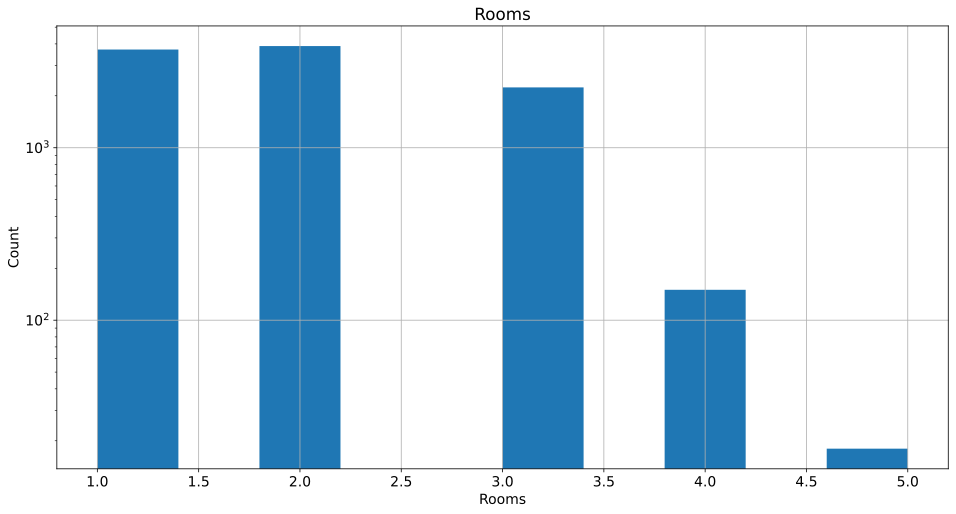

In [59]:
graph_log(train_df, 'Rooms', 10)

### Признак KitchenSquare

In [60]:
train_df['KitchenSquare'].value_counts()

KitchenSquare
1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: count, dtype: int64

In [61]:
train_df['KitchenSquare_outlier'] = 0

In [62]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [63]:
train_df['KitchenSquare'].median()

6.0

In [64]:
train_df['KitchenSquare'].quantile(.975)

13.0

In [65]:
train_df['KitchenSquare'].quantile(.025)

0.0

In [66]:
condition_1 = train_df['KitchenSquare'] >= train_df['KitchenSquare'].quantile(.975)

In [67]:
train_df['KitchenSquare'][condition_1]

120      15.0
147      13.0
186      13.0
227      72.0
280      17.0
        ...  
9860     13.0
9889     51.0
9895    123.0
9910     25.0
9922     14.0
Name: KitchenSquare, Length: 256, dtype: float64

In [68]:
train_df.loc[train_df['KitchenSquare']<5, 'KitchenSquare']

2       0.0
7       0.0
8       1.0
12      1.0
14      1.0
       ... 
9985    1.0
9986    1.0
9987    0.0
9994    1.0
9997    1.0
Name: KitchenSquare, Length: 3222, dtype: float64

In [69]:
# Вспомогательное поле KitchenSquare_outlier с флагом по выбросам более 30 кв.м
train_df.loc[(train_df['KitchenSquare'] > 30), 'KitchenSquare_outlier'] = 1

In [70]:
# замедианим то, что больше 30
train_df.loc[(train_df['KitchenSquare'] > 30), 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [71]:
# Вспомогательное поле KitchenSquare_outlier с флагом по выбросам менее 4 кв.м
train_df.loc[(train_df['KitchenSquare'] < 4), 'KitchenSquare_outlier'] = 1

In [72]:
# замедианим то, что меньше 4
train_df.loc[(train_df['KitchenSquare'] < 4), 'KitchenSquare'] = train_df['KitchenSquare'].median()

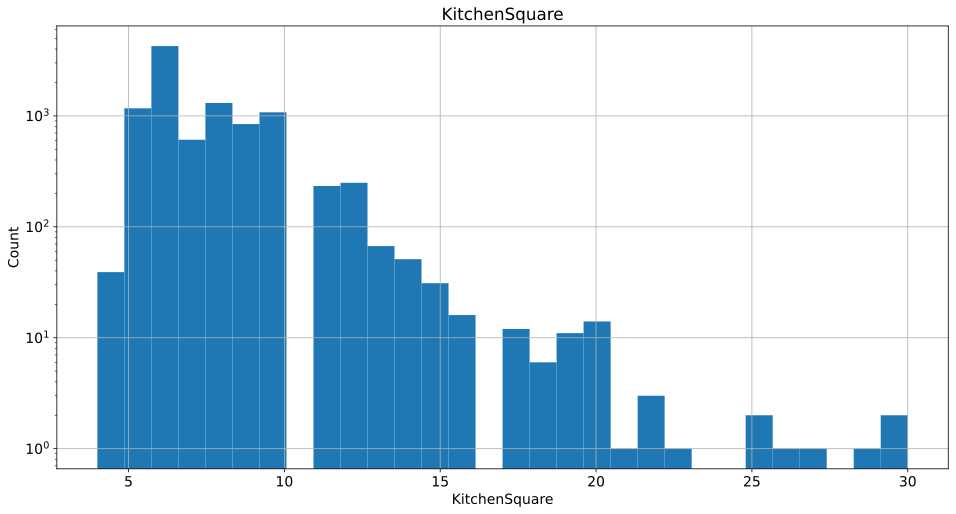

In [73]:
graph_log(train_df, 'KitchenSquare', 30)

In [74]:
train_df['KitchenSquare'].value_counts()

KitchenSquare
6.0     4257
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
22.0       3
30.0       2
25.0       2
26.0       1
23.0       1
29.0       1
21.0       1
27.0       1
Name: count, dtype: int64

In [75]:
train_df['KitchenSquare_outlier'].value_counts()

KitchenSquare_outlier
0    6781
1    3219
Name: count, dtype: int64

In [76]:
train_df['KitchenSquare'].median()

6.0

### Признак Square

In [77]:
train_df[['Square']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Square  10000 non-null  float64
dtypes: float64(1)
memory usage: 78.2 KB


In [78]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [79]:
train_df['Square'].value_counts(bins=20)

Square
(33.133, 65.13]       6978
(65.13, 97.126]       2339
(0.496, 33.133]        372
(97.126, 129.123]      257
(129.123, 161.119]      32
(161.119, 193.115]      15
(193.115, 225.112]       3
(577.072, 609.069]       1
(385.094, 417.09]        1
(609.069, 641.065]       1
(257.108, 289.105]       1
(289.105, 321.101]       0
(353.097, 385.094]       0
(417.09, 449.087]        0
(449.087, 481.083]       0
(481.083, 513.08]        0
(513.08, 545.076]        0
(545.076, 577.072]       0
(225.112, 257.108]       0
(321.101, 353.097]       0
Name: count, dtype: int64

Посмотрим на объекты с площадью более 300 кв.м

In [80]:
train_df[train_df['Square'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier
4262,28,9,2.0,604.705972,NaN,6.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,0,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,0,0
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,0,0


In [81]:
train_df['Square_outlier'] = 0

In [82]:
train_df['LifeSquare_outlier'] = 0

In [83]:
train_df.loc[(train_df['Square'] > 300), 'Square_outlier'] = 1
train_df.loc[(train_df['Square'] > 300), 'LifeSquare_outlier'] = 1

Делим выбросы на 10, т.к. похоже, что шиблись в запятой

In [84]:
train_df.loc[(train_df['Square'] > 300), 'Square'] = train_df['Square']/10 

In [85]:
train_df.loc[(train_df['Square'] > 300), 'LifeSquare'] = train_df['LifeSquare']/10

Посмотрим на объекты с площадью более 200 кв.м

In [86]:
train_df[train_df['Square'] > 200] # оставим как есть, такое вполне может быть

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier
1981,7917,27,3.0,212.932361,211.231125,6.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,1,1,0,0
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666,0,0,0,0
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016,0,0,0,0


 Оставим как есть, такое вполне может быть

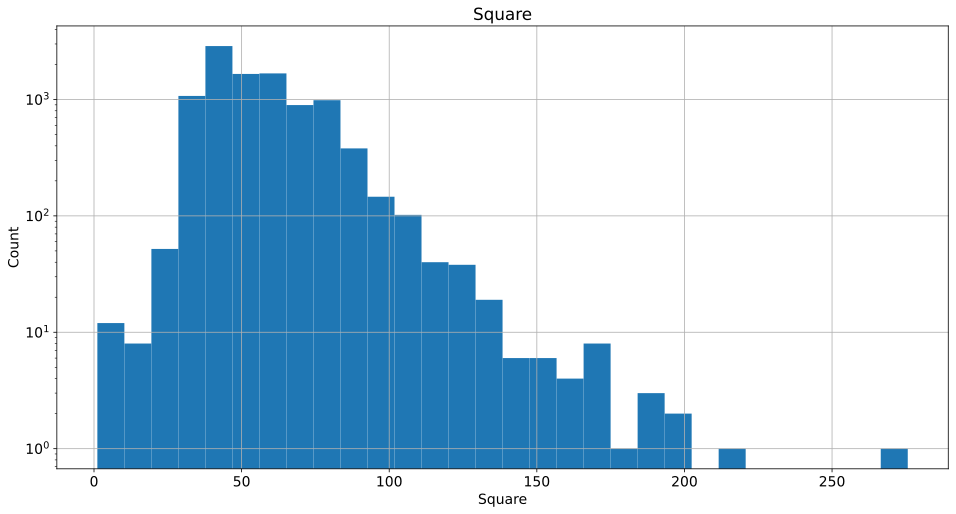

In [87]:
graph_log(train_df, 'Square', 30)

In [88]:
train_df['Square'].quantile(.975)

100.58428965502166

Отрезать данные по этой квантили нет смысла, объектов больше 100 достаточно

In [89]:
train_df['Square'].quantile(.0025)

22.07007929204151

In [90]:
train_df[(train_df['Square'] < 22) & (train_df['Rooms'] > 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier
212,1748,88,2.0,5.497061,67.628717,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,0,0
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186,0,0,0,0
4900,4504,27,3.0,4.390331,5.610772,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,0,0
5617,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A,77835.185808,0,0,0,0
6945,12927,62,2.0,17.414181,NaN,6.0,4,20.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,180750.471749,0,1,0,0
8030,13265,1,3.0,4.823679,79.767964,6.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261,0,1,0,0


In [91]:
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'Square_outlier'] = 1
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'LifeSquare_outlier'] = 1

Создадим поле DELETE Там отметим все подозрительные строки, в достоверности которых есть серьезные сомнения

In [92]:
train_df['DELETE'] = 0

In [93]:
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'DELETE'] = 1

Скорректируем кол-во комнат в квартирах < 20 м

In [94]:
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'Rooms'] = 1

In [95]:
train_df[(train_df['Square'] < 15)] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE
212,1748,88,1.0,5.497061,67.628717,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1
1316,11526,27,1.0,4.633498,1.969969,6.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,0,1,0,0,0
1608,10202,6,1.0,2.596351,4.604943,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,0,0
3280,10527,27,1.0,4.380726,40.805837,6.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,0,1,0,0,0
3413,9487,5,1.0,5.129222,5.549458,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,0,0
4739,12676,81,1.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186,0,0,1,1,1
4853,3224,27,1.0,2.377248,0.873147,6.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,1,1,0,0,0
4900,4504,27,1.0,4.390331,5.610772,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1
6392,14786,1,1.0,1.136859,4.525736,6.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,0,1,0,0,0
8030,13265,1,1.0,4.823679,79.767964,6.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261,0,1,1,1,1


Объекты площадью < 15 м пометим в поле DELETE. Данные по этим объектам вызывают сомнение в их достоверности

In [96]:
train_df.loc[(train_df['Square'] < 15), 'DELETE'] = 1

### Признак LifeSquare

In [97]:
train_df[train_df['LifeSquare'] > train_df['Square']].shape

(483, 25)

483 объекта имеют общую площадь меньше, чем жилую, чего быть не должно.

In [98]:
train_df['test'] = 0

In [99]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']),('LifeSquare')] = (train_df['Square'] - train_df['KitchenSquare'])

In [100]:
train_df.loc[(train_df['LifeSquare'] > 300), 'LifeSquare'] = train_df['LifeSquare']/10

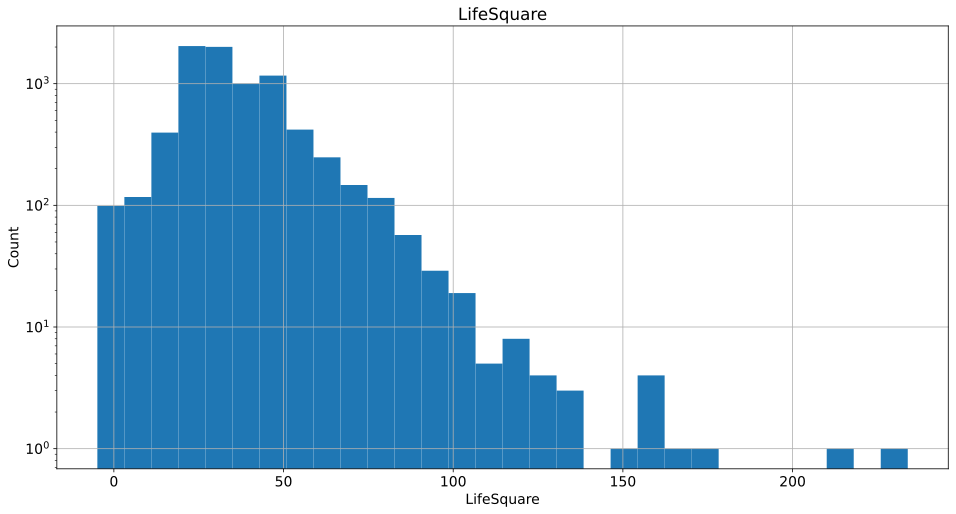

In [101]:
graph_log(train_df, 'LifeSquare', 30)

In [102]:
train_df['LifeSquare'].value_counts(bins=6)

LifeSquare
(-5.103000000000001, 34.939]    4658
(34.939, 74.741]                2980
(74.741, 114.543]                225
(114.543, 154.345]                16
(154.345, 194.147]                 6
(194.147, 233.949]                 2
Name: count, dtype: int64

In [103]:
train_df[train_df['LifeSquare'] < 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
212,1748,88,1.0,5.497061,-0.502939,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1,0
1608,10202,6,1.0,2.596351,-3.403649,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,0,1,0
3280,10527,27,1.0,4.380726,-1.619274,6.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,0,1,0,0,1,0
3413,9487,5,1.0,5.129222,-0.870778,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,0,1,0
4900,4504,27,1.0,4.390331,-1.609669,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1,0
6392,14786,1,1.0,1.136859,-4.863141,6.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,0,1,0,0,1,0
8030,13265,1,1.0,4.823679,-1.176321,6.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261,0,1,1,1,1,0
8283,15744,34,1.0,1.988943,-4.011057,6.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,0,1,0,0,1,0
9294,6782,45,1.0,2.954309,-3.045691,6.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,0,1,0,0,1,0
9613,7657,38,1.0,4.502784,-1.497216,6.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,0,1,0,0,1,0


In [104]:
train_df.loc[161]

Id                               4263
DistrictId                         27
Rooms                             1.0
Square                      54.255191
LifeSquare                  51.135219
KitchenSquare                     6.0
Floor                               5
HouseFloor                        3.0
HouseYear                        2017
Ecology_1                    0.072158
Ecology_2                           B
Ecology_3                           B
Social_1                            2
Social_2                          629
Social_3                            1
Healthcare_1                      NaN
Helthcare_2                         0
Shops_1                             0
Shops_2                             A
Price                    147040.22612
Rooms_outlier                       0
KitchenSquare_outlier               1
Square_outlier                      0
LifeSquare_outlier                  0
DELETE                              0
test                                0
Name: 161, d

In [105]:
train_df.loc[(train_df['LifeSquare'] < 10), 'LifeSquare_outlier'] = 1

In [106]:
train_df.loc[(train_df['LifeSquare'] < 10), 'LifeSquare'] = (train_df['Square'] - train_df['KitchenSquare'])

In [107]:
train_df.loc[(train_df['LifeSquare'] < 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
212,1748,88,1.0,5.497061,-0.502939,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1,0
1316,11526,27,1.0,4.633498,-1.366502,6.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,0,1,0,1,1,0
1608,10202,6,1.0,2.596351,-3.403649,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,1,1,0
3166,15127,150,1.0,17.046188,9.046188,8.0,7,12.0,1982,0.300323,B,B,52,10311,6,NaN,1,9,B,74222.110465,0,0,0,1,0,0
3280,10527,27,1.0,4.380726,-1.619274,6.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,0,1,0,1,1,0
3413,9487,5,1.0,5.129222,-0.870778,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,1,1,0
4739,12676,81,1.0,13.784865,6.784865,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186,0,0,1,1,1,0
4853,3224,27,1.0,2.377248,-3.622752,6.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,1,1,0,1,1,0
4900,4504,27,1.0,4.390331,-1.609669,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1,0
5617,15877,57,1.0,16.547242,8.547242,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A,77835.185808,0,0,1,1,1,0


In [108]:
train_df[pd.isnull(train_df['LifeSquare'])].shape

(2113, 26)

In [109]:
train_df.loc[pd.isnull(train_df['LifeSquare']), 'LifeSquare_outlier'] = 1

In [110]:
train_df.loc[pd.isnull(train_df['LifeSquare']), 'LifeSquare'] = train_df['Square']-train_df['KitchenSquare']

In [111]:
train_df[train_df['Id'] == '11809']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
5544,11809,27,3.0,115.027311,105.027311,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0


In [112]:
train_df.loc[(train_df['LifeSquare'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
212,1748,88,1.0,5.497061,-0.502939,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1,0
1316,11526,27,1.0,4.633498,-1.366502,6.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,0,1,0,1,1,0
1608,10202,6,1.0,2.596351,-3.403649,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,1,1,0
3280,10527,27,1.0,4.380726,-1.619274,6.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,0,1,0,1,1,0
3413,9487,5,1.0,5.129222,-0.870778,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,1,1,0
4853,3224,27,1.0,2.377248,-3.622752,6.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,1,1,0,1,1,0
4900,4504,27,1.0,4.390331,-1.609669,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1,0
6392,14786,1,1.0,1.136859,-4.863141,6.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,0,1,0,1,1,0
8030,13265,1,1.0,4.823679,-1.176321,6.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261,0,1,1,1,1,0
8283,15744,34,1.0,1.988943,-4.011057,6.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,0,1,0,1,1,0


In [113]:
train_df.loc[train_df['LifeSquare'] < 0, 'DELETE'] = 1

In [114]:
train_df.loc[train_df['LifeSquare'] < 0, 'LifeSquare_outlier'] = 1

In [115]:
train_df.loc[train_df['LifeSquare'] < 0, 'LifeSquare'] = train_df['LifeSquare'] * (-1)

In [116]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     10000 non-null  object 
 1   DistrictId             10000 non-null  object 
 2   Rooms                  10000 non-null  float64
 3   Square                 10000 non-null  float64
 4   LifeSquare             10000 non-null  float64
 5   KitchenSquare          10000 non-null  float64
 6   Floor                  10000 non-null  int64  
 7   HouseFloor             10000 non-null  float64
 8   HouseYear              10000 non-null  int64  
 9   Ecology_1              10000 non-null  float64
 10  Ecology_2              10000 non-null  object 
 11  Ecology_3              10000 non-null  object 
 12  Social_1               10000 non-null  int64  
 13  Social_2               10000 non-null  int64  
 14  Social_3               10000 non-null  int64  
 15  Hea

### Признак Floor

In [117]:
train_df[['Floor']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Floor   10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [118]:
train_df['Floor'].value_counts()

Floor
4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
31      1
37      1
33      1
Name: count, dtype: int64

In [119]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [120]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5)].shape

(887, 26)

In [121]:
train_df['Floor_outlier'] = 0

In [122]:
train_df['HouseFloor_outlier'] = 0

In [123]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor_outlier'] = 1

In [124]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'HouseFloor_outlier'] = 1 

In [125]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'HouseFloor'].value_counts()

HouseFloor
1.0    484
0.0    269
3.0     63
4.0     41
2.0     30
Name: count, dtype: int64

In [126]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'HouseFloor'] = train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'Floor']

In [127]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = train_df['HouseFloor']

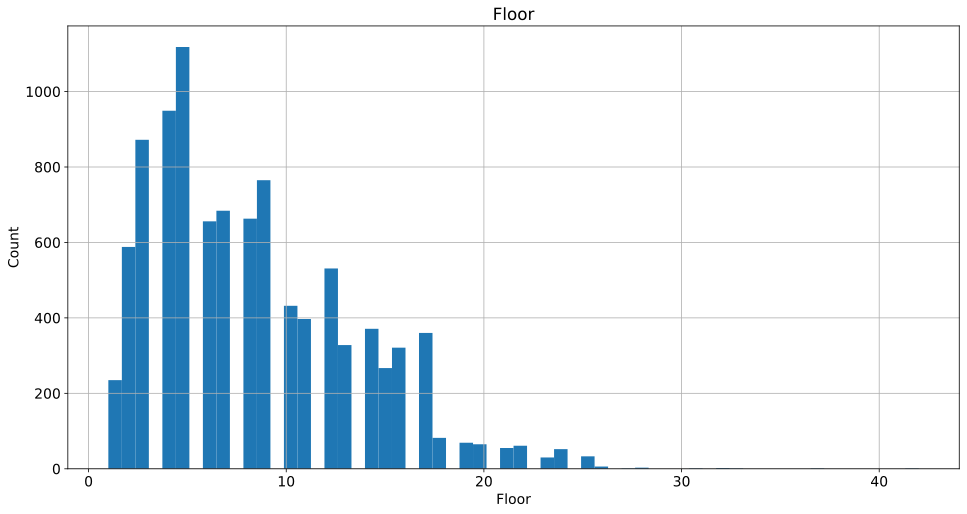

In [128]:
graph(train_df, 'Floor', 60)

In [129]:
train_df['Floor'].value_counts()

Floor
5     1118
4      949
3      872
9      765
7      684
8      663
6      656
2      588
12     531
10     432
11     397
14     371
17     360
13     328
16     321
15     267
1      235
18      82
19      69
20      65
22      61
21      55
24      52
25      33
23      30
26       6
28       3
32       2
42       1
27       1
31       1
37       1
33       1
Name: count, dtype: int64

In [130]:
train_df[train_df['HouseFloor']>50].sort_values('HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier
6131,10806,5,1.0,51.944587,48.709601,6.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515,0,1,0,0,0,0,0,0
8599,9300,74,2.0,71.747869,62.747869,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579,0,0,0,0,0,0,0,0
8854,78,30,2.0,65.773749,59.773749,6.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520,0,1,0,0,0,0,0,0


In [131]:
train_df.loc[train_df['HouseFloor']>50, 'HouseFloor_outlier'] = 1

In [132]:
train_df.loc[train_df['HouseFloor']>50, 'HouseFloor'] = round(train_df['HouseFloor']/10)

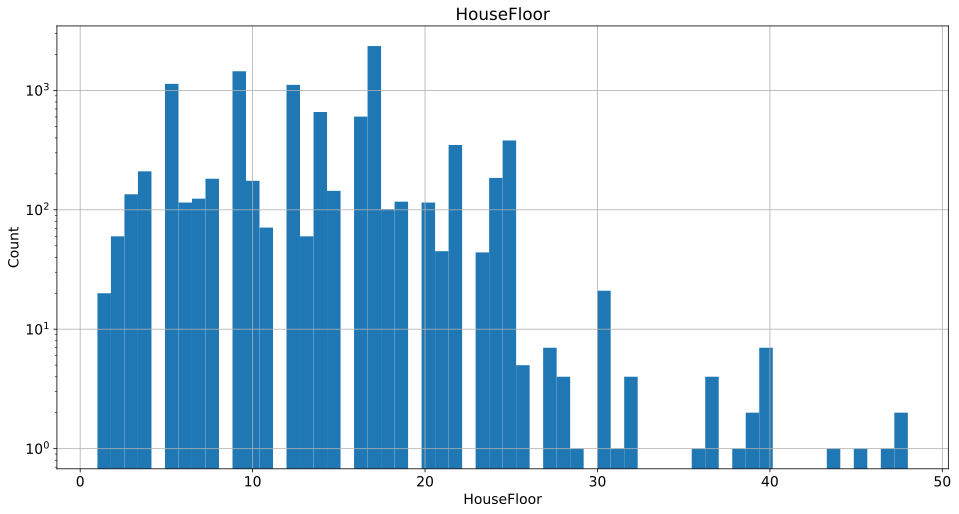

In [133]:
graph_log(train_df, 'HouseFloor', 60)

In [134]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     10000 non-null  object 
 1   DistrictId             10000 non-null  object 
 2   Rooms                  10000 non-null  float64
 3   Square                 10000 non-null  float64
 4   LifeSquare             10000 non-null  float64
 5   KitchenSquare          10000 non-null  float64
 6   Floor                  10000 non-null  int64  
 7   HouseFloor             10000 non-null  float64
 8   HouseYear              10000 non-null  int64  
 9   Ecology_1              10000 non-null  float64
 10  Ecology_2              10000 non-null  object 
 11  Ecology_3              10000 non-null  object 
 12  Social_1               10000 non-null  int64  
 13  Social_2               10000 non-null  int64  
 14  Social_3               10000 non-null  int64  
 15  Hea

### Признак HouseYear

In [135]:
train_df[['HouseYear']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   HouseYear  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [136]:
train_df['HouseYear'].value_counts()

HouseYear
1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
4968       1
1914       1
1916       1
1910       1
1928       1
Name: count, Length: 97, dtype: int64

In [137]:
train_df['HouseYear'].value_counts(bins =5)

HouseYear
(-18140.102, 4011930.2]     9999
(16041990.8, 20052011.0]       1
(4011930.2, 8021950.4]         0
(8021950.4, 12031970.6]        0
(12031970.6, 16041990.8]       0
Name: count, dtype: int64

In [138]:
train_df['HouseYear'].mode()

0    1977
Name: HouseYear, dtype: int64

In [139]:
train_df['HouseYear_outlier'] = 0

In [140]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear_outlier'] = 1

In [141]:
train_df.loc[train_df['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396,0,0,0,0,0,0,0,0,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096,0,0,0,0,0,0,0,0,1


In [142]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [143]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

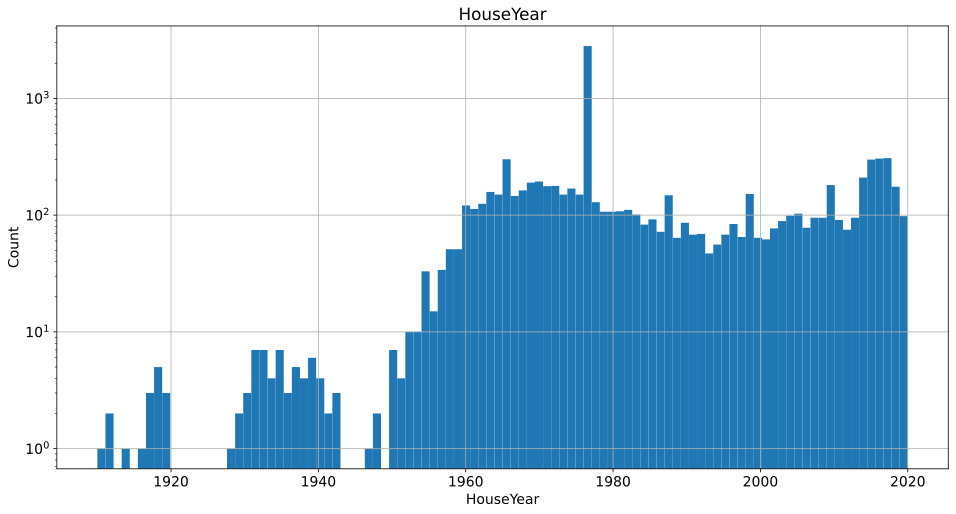

In [144]:
graph_log(train_df, 'HouseYear', 100)

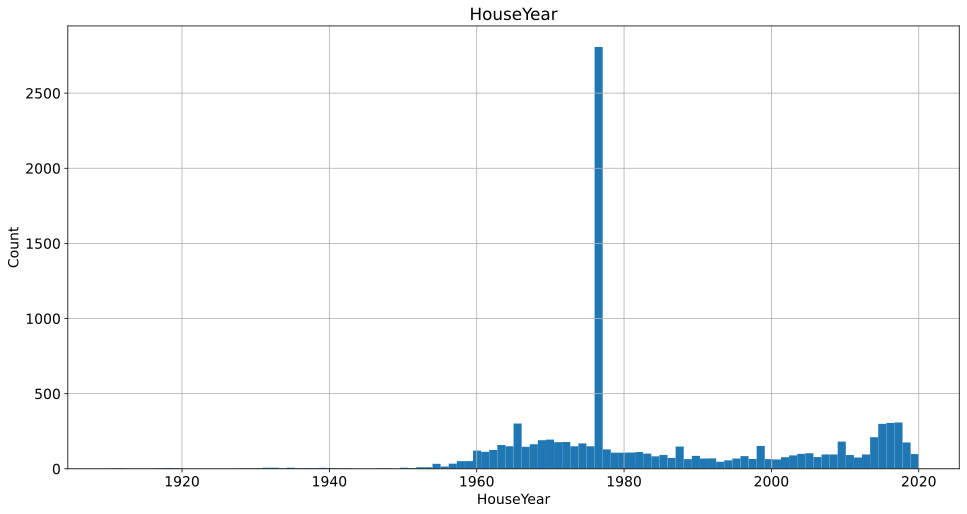

In [145]:
graph(train_df, 'HouseYear', 100)

Оставляем значение 1977, не считаем это за выброс

In [146]:
train_df['HouseYear'].value_counts(bins =5)

HouseYear
(1976.0, 1998.0]                4387
(1954.0, 1976.0]                2811
(1998.0, 2020.0]                2681
(1932.0, 1954.0]                  90
(1909.8890000000001, 1932.0]      31
Name: count, dtype: int64

In [147]:
train_df['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [148]:
train_df[train_df['HouseYear'] == 1977].shape

(2652, 29)

### Признак Ecology_1

In [149]:
train_df[['Ecology_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ecology_1  10000 non-null  float64
dtypes: float64(1)
memory usage: 78.2 KB


In [150]:
train_df[['Ecology_1']].describe()

,Ecology_1
count,10000.000000
mean,0.118858
std,0.119025
min,0.000000
25%,0.017647
50%,0.075424
75%,0.195781
max,0.521867


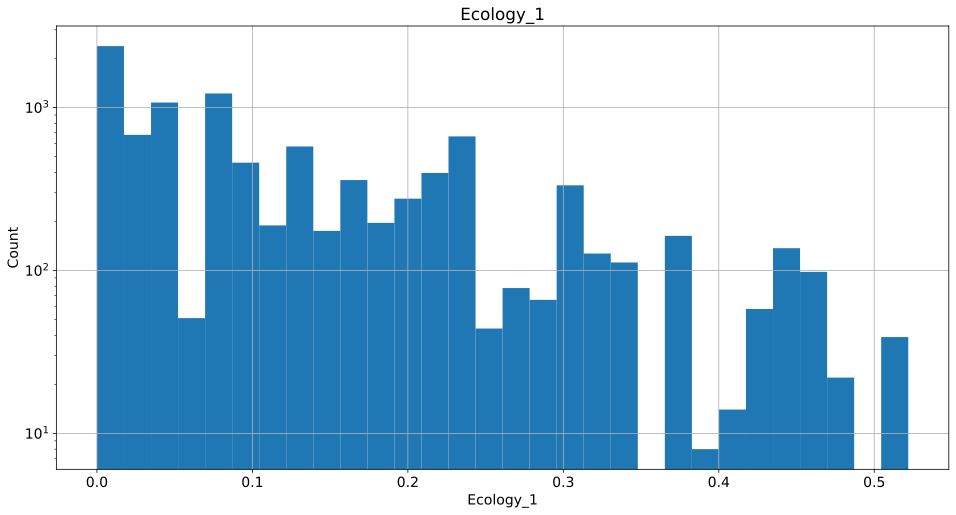

In [151]:
graph_log(train_df, 'Ecology_1', 30)

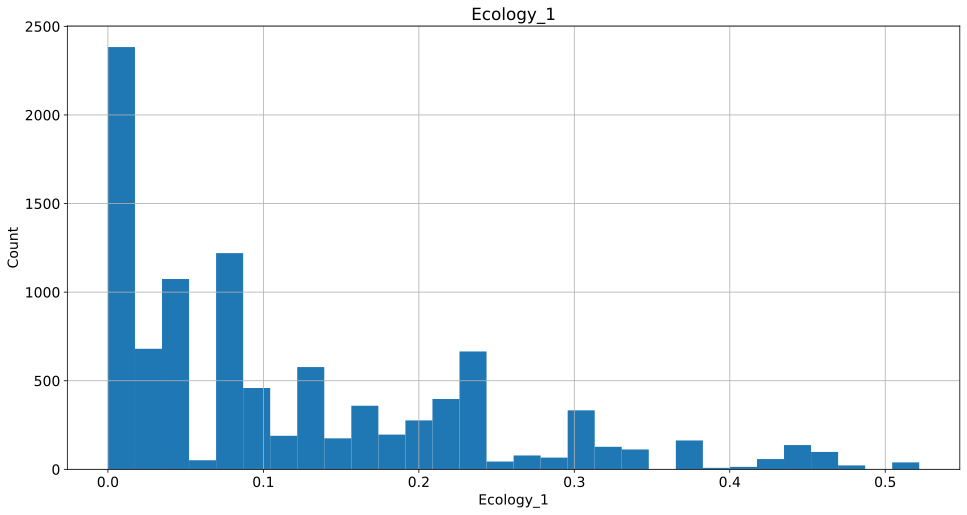

In [152]:
graph(train_df, 'Ecology_1', 30)

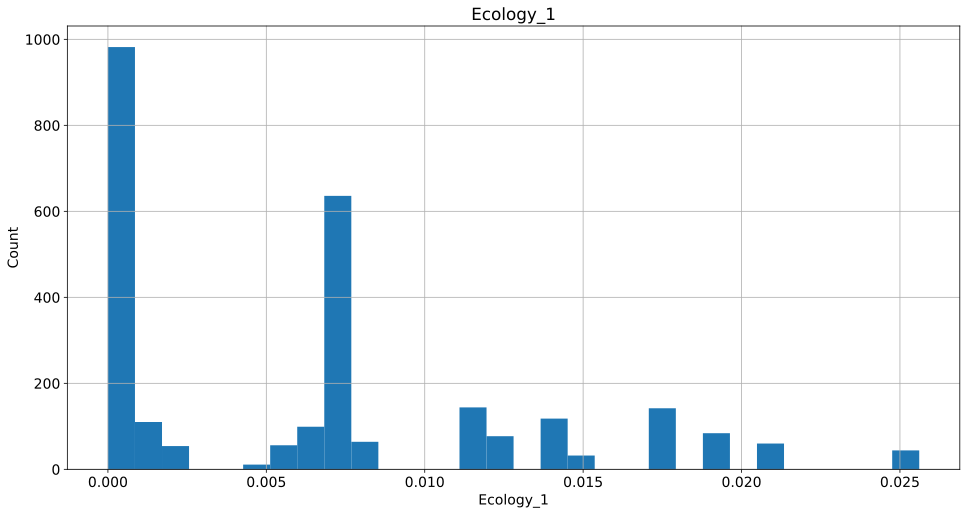

In [153]:
graph((train_df[train_df['Ecology_1'] < train_df['Ecology_1'].quantile(0.275)]), 'Ecology_1', 30)

In [154]:
train_df['Ecology_1_outlier'] = 0

In [155]:
train_df['Ecology_1'].quantile(0.975)

0.43788524

In [156]:
train_df[train_df['Ecology_1'] > train_df['Ecology_1'].quantile(0.975)].shape

(159, 30)

Что можно поменять?

In [157]:
quant = train_df['Ecology_1'].quantile(0.275)
count = train_df.loc[(train_df['Ecology_1'] < quant), 'Ecology_1'].count()
print(quant, '\n', count)

0.033493708 
 2713


In [158]:
print((train_df['Ecology_1'].mode()),'\n' ,(train_df['Ecology_1'].mean()))

0    0.007122
Name: Ecology_1, dtype: float64 
 0.11885751885428997


In [159]:
train_df[train_df['Ecology_1'] < train_df['Ecology_1'].quantile(0.275)].shape

(2713, 30)

In [160]:
train_df[train_df['Ecology_1'] <= 0].shape

(537, 30)

In [161]:
train_df['Ecology_1'].value_counts()

Ecology_1
0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.014334      1
0.012522      1
Name: count, Length: 129, dtype: int64

In [162]:
train_df['Ecology_1'].sort_values().unique()

array([0.00000000e+00, 1.80000000e-09, 6.99893000e-05, 7.81528000e-05,
       1.69676000e-04, 6.99119000e-04, 9.91363000e-04, 9.95363000e-04,
       2.21166500e-03, 4.94935800e-03, 5.76745100e-03, 6.07615200e-03,
       7.12231700e-03, 7.65851500e-03, 7.72028200e-03, 1.13198100e-02,
       1.16541270e-02, 1.23388860e-02, 1.25216340e-02, 1.40579200e-02,
       1.40729610e-02, 1.43339470e-02, 1.44231140e-02, 1.45807160e-02,
       1.50168920e-02, 1.76470530e-02, 1.95087960e-02, 2.07413260e-02,
       2.56091570e-02, 3.34937080e-02, 3.43314970e-02, 3.46560820e-02,
       3.51452670e-02, 3.61222920e-02, 3.62700890e-02, 3.71778180e-02,
       3.73164520e-02, 3.86929870e-02, 4.02427640e-02, 4.11163540e-02,
       4.11246340e-02, 4.13654460e-02, 4.20315870e-02, 4.23072710e-02,
       4.96372570e-02, 4.98633870e-02, 5.02720140e-02, 5.07555690e-02,
       5.09000580e-02, 5.18154350e-02, 5.19420620e-02, 6.07530490e-02,
       6.96603440e-02, 6.97533610e-02, 7.21575810e-02, 7.54236800e-02,
      

In [163]:
train_df['Ecology_1_q'] = train_df['Ecology_1'] # дублирующий столбец

In [164]:
train_df['Ecology_1_q_outlier'] = 0

In [165]:
train_df.loc[(train_df['Ecology_1_q'] < train_df['Ecology_1_q'].quantile(0.275)), 'Ecology_1_q_outlier'] = 1
train_df.loc[(train_df['Ecology_1_q'] < train_df['Ecology_1_q'].quantile(0.275)), 'Ecology_1_q'] = (train_df['Ecology_1'].mean())

In [166]:
train_df.loc[(train_df['Ecology_1_q'] > train_df['Ecology_1_q'].quantile(0.975)), 'Ecology_1_q_outlier'] = 1
train_df.loc[(train_df['Ecology_1_q'] > train_df['Ecology_1_q'].quantile(0.975)), 'Ecology_1_q'] = (train_df['Ecology_1'].mean())

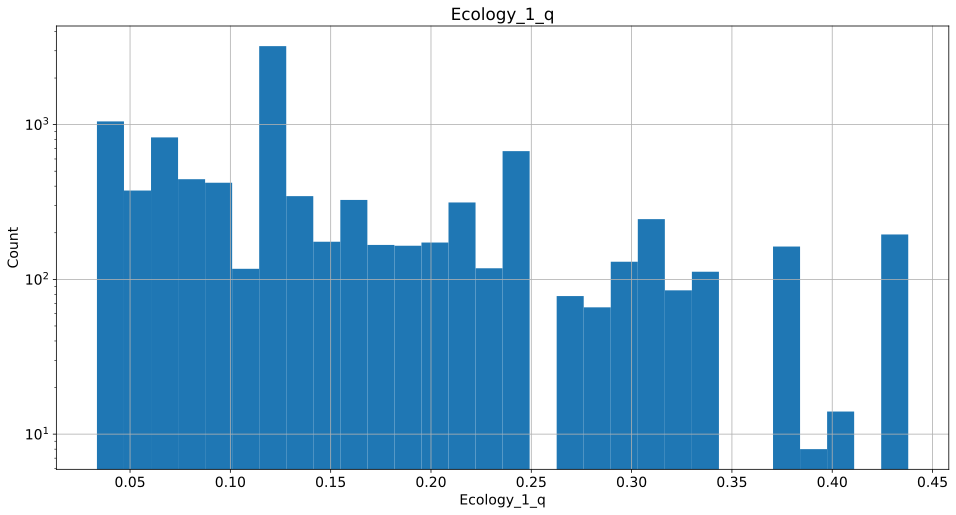

In [167]:
graph_log(train_df, 'Ecology_1_q', 30)

Сохраняем результат

In [168]:
train_df.to_csv('./train_save.csv', index=False, encoding='utf-8', sep=';')

### Признак Ecology_2

In [169]:
train_df[['Ecology_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ecology_2  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [170]:
train_df['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

In [171]:
train_df['Ecology_2'].value_counts()

Ecology_2
B    9903
A      97
Name: count, dtype: int64

In [172]:
pd.get_dummies(train_df['Ecology_2'])

,A,B
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
9995,False,True
9996,False,True
9997,False,True
9998,False,True


In [173]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'])], axis=1)

In [174]:
train_df.rename(columns={'A': 'Ecology_2_A'}, inplace=True)

In [175]:
train_df.rename(columns={'B': 'Ecology_2_B'}, inplace=True)

In [176]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,0,0,0,0,0,0,0,0,0,0,0.089040,0,False,True
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,0,0,0,0,0,0,0,0,0,0.118858,1,False,True
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,0,0,0,0,0,0,0,0.049637,0,False,True
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,0,0,0,0,0,0,0,0,0,0.437885,0,False,True
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,0,0,0,0,0,0,0,0,0,0.118858,1,False,True


### Признак Ecology_2

In [177]:
train_df[['Ecology_3']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ecology_3  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [178]:
train_df['Ecology_3'].value_counts()

Ecology_3
B    9725
A     275
Name: count, dtype: int64

In [179]:
Eco_3 = {'A': 0, 'B': 1}
train_df['Ecology_3_01'] = train_df['Ecology_3'].map(Eco_3)

In [180]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,0,0,0,0,0,0,0,0,0,0,0.089040,0,False,True,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,0,0,0,0,0,0,0,0.049637,0,False,True,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,0,0,0,0,0,0,0,0,0,0.437885,0,False,True,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1


### Признак Social_1

In [181]:
train_df[['Social_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_1  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [182]:
train_df[['Social_1']].describe()

,Social_1
count,10000.000000
mean,24.687000
std,17.532614
min,0.000000
25%,6.000000
50%,25.000000
75%,36.000000
max,74.000000


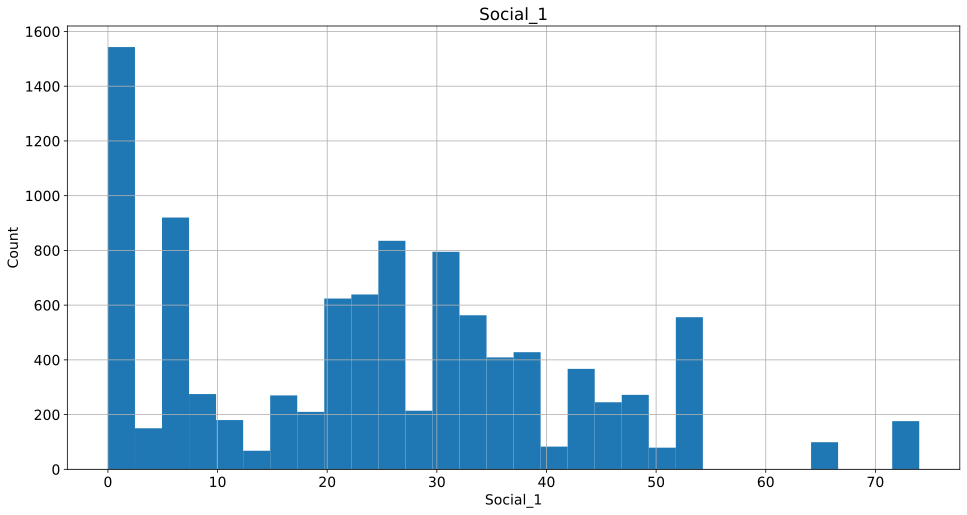

In [183]:
graph(train_df, 'Social_1', 30)

In [184]:
train_df['Social_1'].quantile(0.975)

66.0

In [185]:
train_df['Social_1'].quantile(0.025)

1.0

In [186]:
train_df['Social_1'].mean()

24.687

In [187]:
train_df['Social_1_q'] = train_df['Social_1']
train_df['Social_1_q_outlier'] = 0

In [188]:
train_df.loc[(train_df['Social_1_q'] < train_df['Social_1'].quantile(0.025))].shape

(201, 37)

In [189]:
train_df.loc[(train_df['Social_1_q'] < train_df['Social_1'].quantile(0.025)), 'Social_1_q_outlier'] = 1 

In [190]:
train_df.loc[(train_df['Social_1_q'] < train_df['Social_1'].quantile(0.025)), 'Social_1_q'] = train_df['Social_1'].mean() 

In [191]:
train_df.loc[(train_df['Social_1_q'] > train_df['Social_1'].quantile(0.975)), 'Social_1_q_outlier'] = 1 

In [192]:
train_df.loc[(train_df['Social_1_q'] > train_df['Social_1'].quantile(0.925)), 'Social_1_q'] = train_df['Social_1'].mean() 

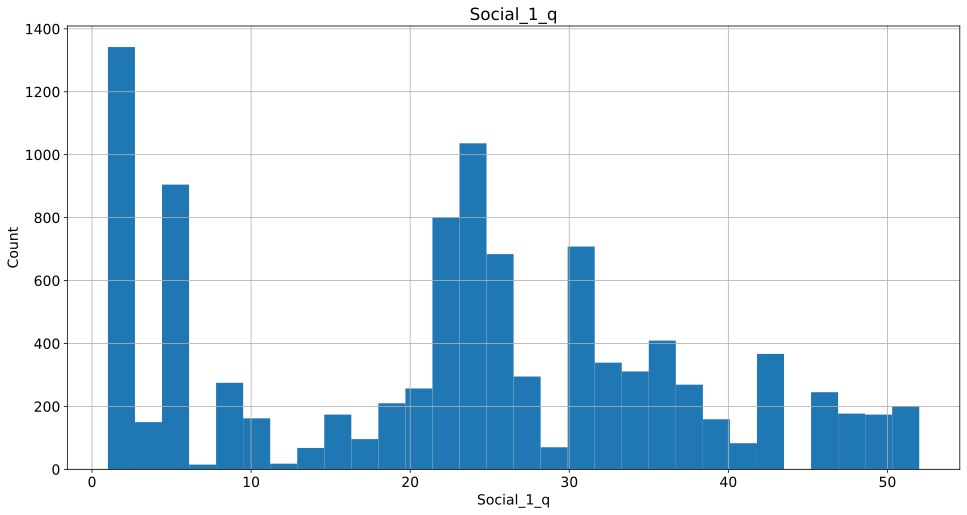

In [193]:
graph(train_df, 'Social_1_q', 30)

In [194]:
train_df['Social_1'].value_counts()

Social_1
2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
24    205
37    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: count, dtype: int64

### Признак Social_2

In [195]:
train_df['Social_2'].value_counts()

Social_2
264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
528       1
507       1
Name: count, Length: 142, dtype: int64

In [196]:
train_df[['Social_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_2  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [197]:
train_df[['Social_2']].describe()

,Social_2
count,10000.000000
mean,5352.157400
std,4006.799803
min,168.000000
25%,1564.000000
50%,5285.000000
75%,7227.000000
max,19083.000000


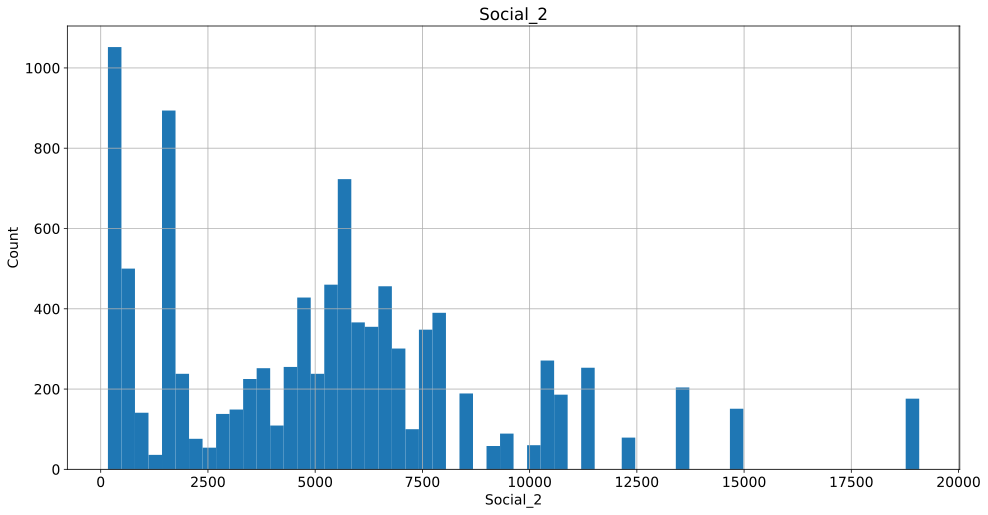

In [198]:
graph(train_df, 'Social_2', 60)

In [199]:
train_df['Social_2'].quantile(0.975)

14892.0

In [200]:
train_df['Social_2'].quantile(0.025)

264.0

In [201]:
train_df['Social_2'].mean()

5352.1574

In [202]:
train_df['Social_2'].mode()

0    264
Name: Social_2, dtype: int64

In [203]:
train_df['Social_2_q'] = train_df['Social_2']
train_df['Social_2_q_outlier'] = 0

In [204]:
train_df.loc[(train_df['Social_2_q'] < train_df['Social_2'].quantile(0.025))][['Social_1','Social_2']]

,Social_1,Social_2
28,0,168
39,0,168
46,0,168
103,0,168
152,0,168
...,...,...
9827,0,168
9843,0,168
9903,0,168
9961,0,168


In [205]:
train_df.loc[(train_df['Social_2_q'] < train_df['Social_2'].quantile(0.025)), 'Social_2_q_outlier'] = 1 

In [206]:
train_df.loc[(train_df['Social_2_q'] < train_df['Social_2'].quantile(0.025)), 'Social_2_q'] = train_df['Social_2'].mean() 

In [207]:
train_df.loc[(train_df['Social_2_q'] > train_df['Social_2'].quantile(0.975)), 'Social_2_q_outlier'] = 1 

In [208]:
train_df.loc[(train_df['Social_2_q'] > train_df['Social_2'].quantile(0.925)), 'Social_2_q'] = train_df['Social_2'].mean() 

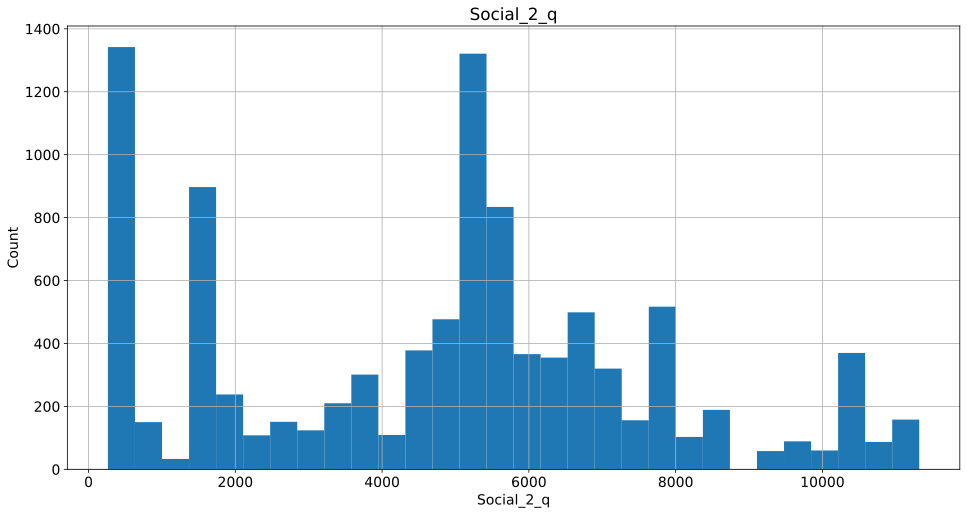

In [209]:
graph(train_df, 'Social_2_q', 30)

In [210]:
train_df['Social_2'].value_counts()

Social_2
264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
528       1
507       1
Name: count, Length: 142, dtype: int64

### Признак Social_3

In [211]:
train_df[['Social_3']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_3  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [212]:
train_df[['Social_3']].describe()

,Social_3
count,10000.000000
mean,8.039200
std,23.831875
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,141.000000


In [213]:
train_df['Social_3'].value_counts()

Social_3
0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: count, dtype: int64

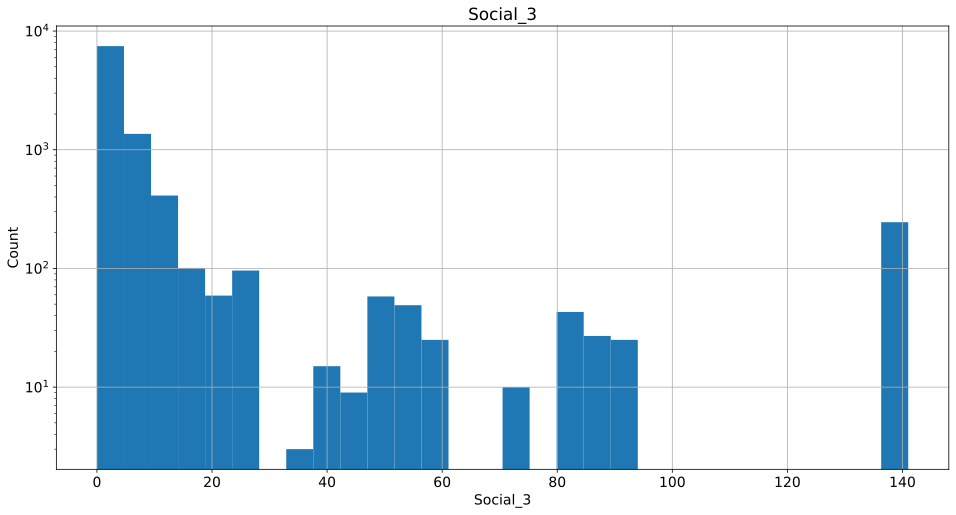

In [214]:
graph_log(train_df, 'Social_3', 30)

In [215]:
train_df['Social_3'].quantile(0.975)

93.0

In [216]:
train_df['Social_3'].quantile(0.025)

0.0

In [217]:
train_df['Social_3'].mean()

8.0392

In [218]:
train_df['Social_3_q'] = train_df['Social_3']
train_df['Social_3_q_outlier'] = 0

In [219]:
train_df.loc[(train_df['Social_3_q'] < train_df['Social_3'].quantile(0.025))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier


In [220]:
train_df.loc[(train_df['Social_3_q'] > train_df['Social_3'].quantile(0.975))]['Social_3_q'].value_counts()

Social_3_q
141    245
Name: count, dtype: int64

In [221]:
train_df.loc[(train_df['Social_3_q'] > train_df['Social_3'].quantile(0.975)), 'Social_3_q_outlier'] = 1 

In [222]:
train_df.loc[(train_df['Social_3_q'] > train_df['Social_3'].quantile(0.975)), 'Social_3_q'] = train_df['Social_3'].mean() 

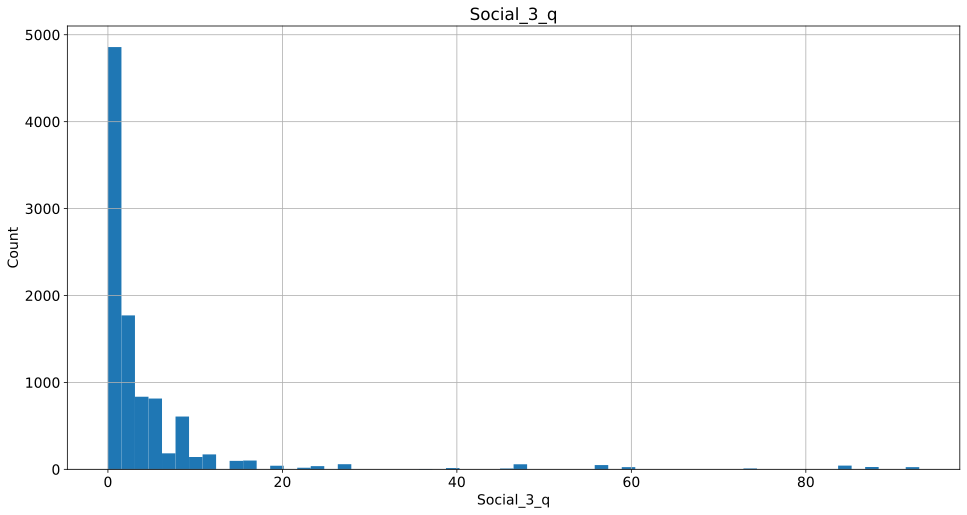

In [223]:
graph(train_df, 'Social_3_q', 60)

### Признак Healthcare_1

In [224]:
train_df[['Healthcare_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Healthcare_1  5202 non-null   float64
dtypes: float64(1)
memory usage: 78.2 KB


In [225]:
train_df['Healthcare_1'].value_counts(bins = 5)

Healthcare_1
(-4.8500000000000005, 969.8]    2631
(969.8, 1939.6]                 1538
(1939.6, 2909.4]                 778
(3879.2, 4849.0]                 170
(2909.4, 3879.2]                  85
Name: count, dtype: int64

In [226]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

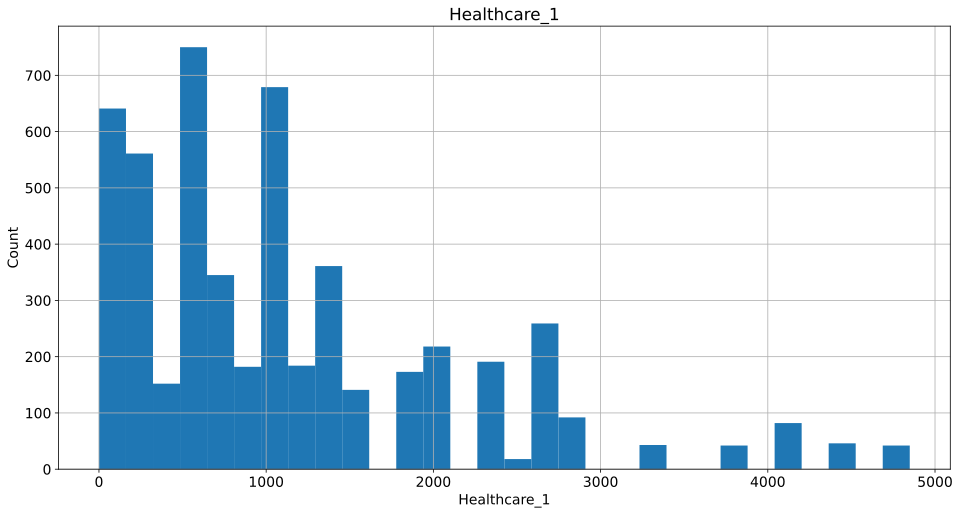

In [227]:
graph(train_df, 'Healthcare_1', 30)

In [228]:
train_df['Healthcare_1'].quantile(0.975)

4087.0

In [229]:
train_df['Healthcare_1'].quantile(0.025)

30.0

In [230]:
train_df['Healthcare_1'].mean()

1142.9044598231449

In [231]:
train_df['Healthcare_1_q'] = train_df['Healthcare_1']
train_df['Healthcare_1_q_outlier'] = 0

In [232]:
train_df.loc[(train_df['Healthcare_1_q'] <= train_df['Healthcare_1'].quantile(0.025))].shape

(349, 43)

In [233]:
train_df[(train_df['Healthcare_1_q'] < 35)]['Healthcare_1_q'].value_counts()

Healthcare_1_q
30.0    348
32.0     12
0.0       1
Name: count, dtype: int64

In [234]:
train_df.loc[(train_df['Healthcare_1_q'] < train_df['Healthcare_1'].quantile(0.025)), 'Healthcare_1_q_outlier'] = 1

In [235]:
train_df.loc[(train_df['Healthcare_1_q'] < train_df['Healthcare_1'].quantile(0.025)), 'Healthcare_1_q'] = train_df['Healthcare_1'].mean()

In [236]:
train_df[(train_df['Healthcare_1_q'] > train_df['Healthcare_1'].quantile(0.975))]['Healthcare_1_q'].value_counts()

Healthcare_1_q
4508.0    46
4129.0    37
4702.0    27
4849.0    15
Name: count, dtype: int64

In [237]:
train_df.loc[(train_df['Healthcare_1_q'] > train_df['Healthcare_1'].quantile(0.975)), 'Healthcare_1_q_outlier'] = 1

In [238]:
train_df.loc[(train_df['Healthcare_1_q'] > train_df['Healthcare_1'].quantile(0.975)), 'Healthcare_1_q'] = train_df['Healthcare_1'].mean()

In [239]:
train_df[pd.isnull(train_df['Healthcare_1_q'])]['Healthcare_1_q']

0      NaN
6      NaN
7      NaN
8      NaN
9      NaN
        ..
9992   NaN
9993   NaN
9994   NaN
9996   NaN
9997   NaN
Name: Healthcare_1_q, Length: 4798, dtype: float64

In [240]:
train_df.loc[pd.isnull(train_df['Healthcare_1_q']),'Healthcare_1_q_outlier'] = 1

In [241]:
train_df.loc[pd.isnull(train_df['Healthcare_1_q']),'Healthcare_1_q'] = train_df['Healthcare_1'].mean()

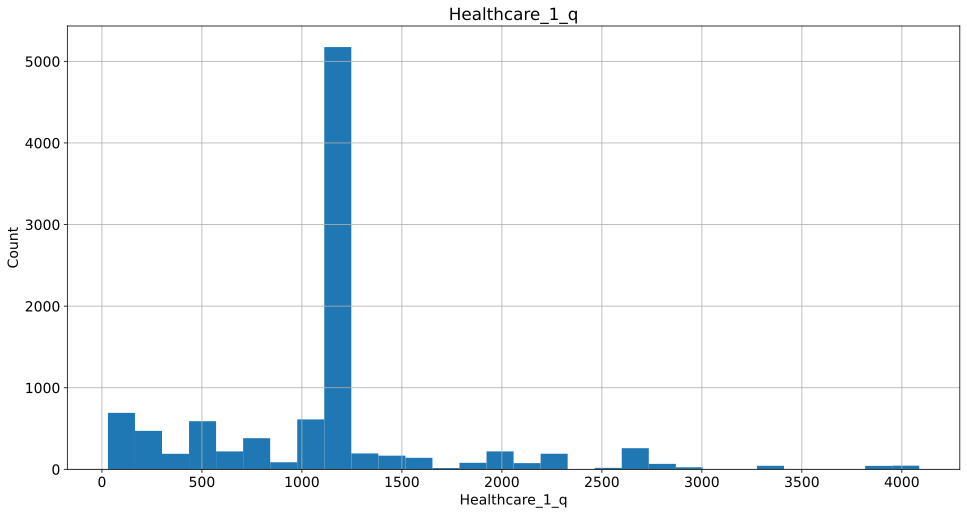

In [242]:
graph(train_df, 'Healthcare_1_q', 30)

### Признак Helthcare_2

In [243]:
train_df[['Helthcare_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Helthcare_2  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [244]:
train_df[['Helthcare_2']].describe()

,Helthcare_2
count,10000.000000
mean,1.319500
std,1.493601
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,6.000000


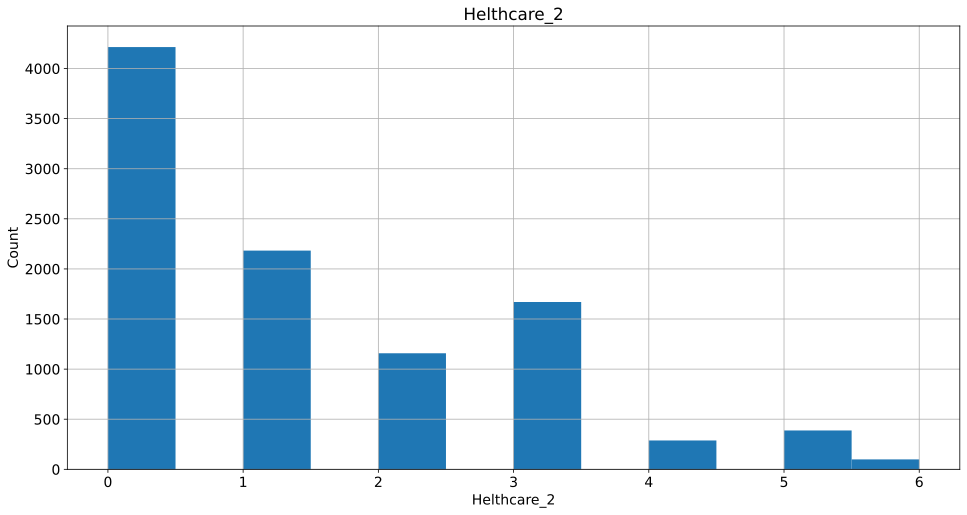

In [245]:
graph(train_df, 'Helthcare_2', 12)

In [246]:
train_df['Helthcare_2'].value_counts()

Helthcare_2
0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: count, dtype: int64

Признак 'Helthcare_2' оставляем без изменений. Выбросов и пропусков нет.

### Признак Shops_1

In [247]:
train_df[['Shops_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Shops_1  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [248]:
train_df[['Shops_1']].describe()

,Shops_1
count,10000.000000
mean,4.231300
std,4.806341
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,23.000000


In [249]:
train_df['Shops_1'].value_counts()

Shops_1
0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: count, dtype: int64

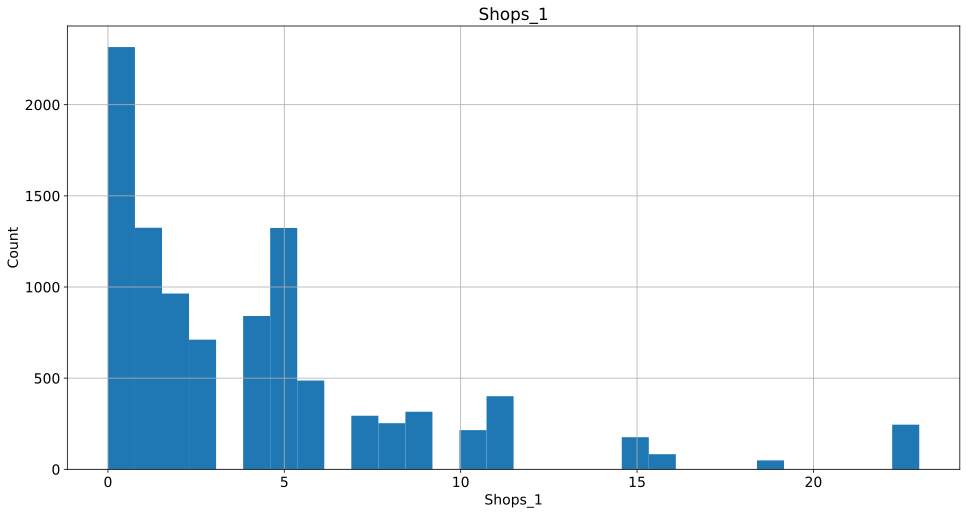

In [250]:
graph(train_df, 'Shops_1', 30)

In [251]:
train_df['Shops_1'].quantile(0.975)

19.0

In [252]:
train_df[(train_df['Shops_1'] > train_df['Shops_1'].quantile(0.975))]['Shops_1'].count()

245

In [253]:
train_df['Shops_1'].quantile(0.025)

0.0

In [254]:
round(train_df['Shops_1'].mean())

4

In [255]:
train_df['Shops_1_q'] = train_df['Shops_1']
train_df['Shops_1_q_outlier'] = 0

In [256]:
train_df.loc[(train_df['Shops_1_q'] > train_df['Shops_1_q'].quantile(0.975)), 'Shops_1_q_outlier'] = 1 

In [257]:
train_df.loc[(train_df['Shops_1_q'] > train_df['Shops_1_q'].quantile(0.975)), 'Shops_1_q'] = round(train_df['Shops_1'].mean()) 

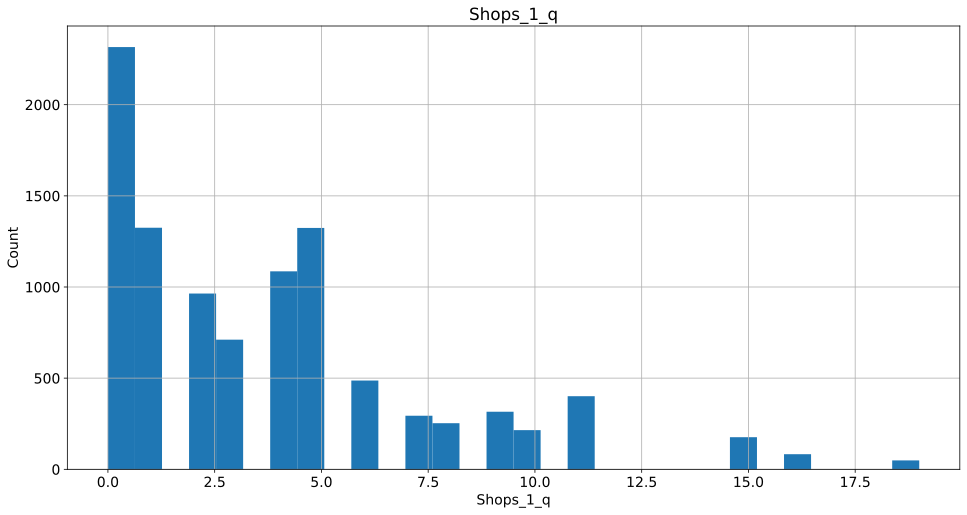

In [258]:
graph(train_df, 'Shops_1_q', 30)

### Признак Shops

In [259]:
train_df[['Shops_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Shops_2  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [260]:
train_df[['Shops_2']].describe()

,Shops_2
count,10000
unique,2
top,B
freq,9175


In [261]:
train_df['Shops_2'].value_counts()

Shops_2
B    9175
A     825
Name: count, dtype: int64

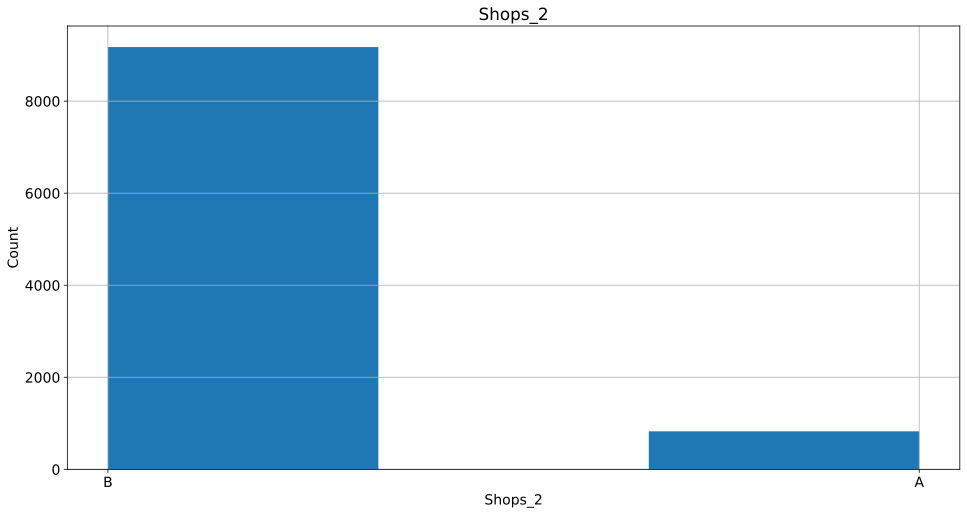

In [262]:
graph(train_df, 'Shops_2', 3)

In [263]:
Sh_2 = {'A': 0, 'B': 1}

In [264]:
train_df['Shops_2_01'] = train_df['Shops_2'].map(Sh_2)

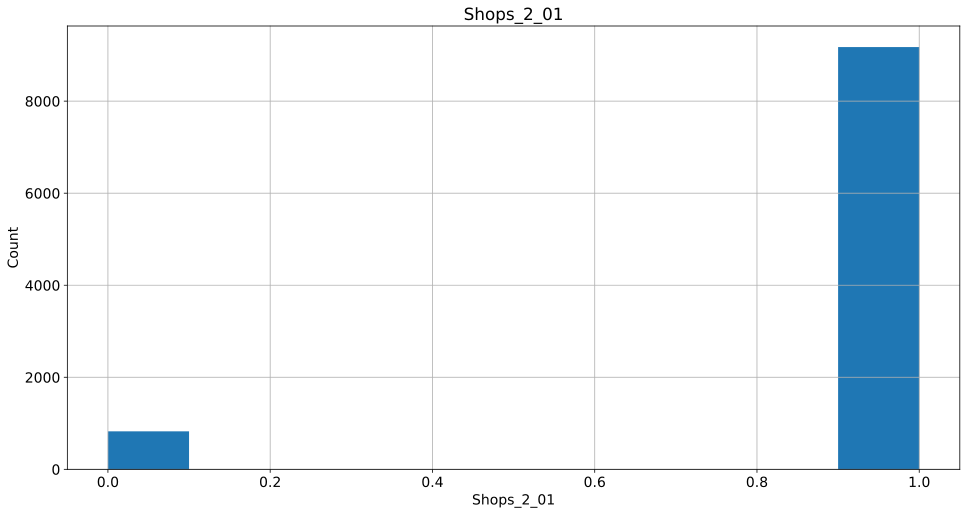

In [265]:
graph(train_df, 'Shops_2_01', 10)

In [266]:
train_df.drop(columns = 'test', inplace = True)

In [267]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      10000 non-null  object 
 1   DistrictId              10000 non-null  object 
 2   Rooms                   10000 non-null  float64
 3   Square                  10000 non-null  float64
 4   LifeSquare              10000 non-null  float64
 5   KitchenSquare           10000 non-null  float64
 6   Floor                   10000 non-null  int64  
 7   HouseFloor              10000 non-null  float64
 8   HouseYear               10000 non-null  int64  
 9   Ecology_1               10000 non-null  float64
 10  Ecology_2               10000 non-null  object 
 11  Ecology_3               10000 non-null  object 
 12  Social_1                10000 non-null  int64  
 13  Social_2                10000 non-null  int64  
 14  Social_3                10000 non-null 

### Генерация новых признаков

In [268]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'count':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [269]:
district_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DistrictId    205 non-null    object
 1   DistrictSize  205 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [270]:
train_df[['DistrictId']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DistrictId  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [271]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,0,0,0,0,0,0,0,0,0,0.089040,0,False,True,1,33.0,0,7976.0,0,5.0,0,1142.90446,1,11,0,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,46.0,0,10309.0,0,1.0,0,240.00000,0,16,0,1,87
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,0,0,0,0,0,0,0.049637,0,False,True,1,34.0,0,7759.0,0,0.0,0,229.00000,0,3,0,1,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,0,0,0,0,0,0,0,0,0.437885,0,False,True,1,23.0,0,5735.0,0,3.0,0,1084.00000,0,5,0,1,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,35.0,0,5776.0,0,1.0,0,2078.00000,0,4,0,1,97


In [272]:
(train_df['DistrictSize'] > 100).value_counts()

DistrictSize
True     5069
False    4931
Name: count, dtype: int64

In [273]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,0,0,0,0,0,0,0,0,0,0.089040,0,False,True,1,33.0,0,7976.0,0,5.0,0,1142.90446,1,11,0,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,46.0,0,10309.0,0,1.0,0,240.00000,0,16,0,1,87
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,0,0,0,0,0,0,0.049637,0,False,True,1,34.0,0,7759.0,0,0.0,0,229.00000,0,3,0,1,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,0,0,0,0,0,0,0,0,0.437885,0,False,True,1,23.0,0,5735.0,0,3.0,0,1084.00000,0,5,0,1,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,35.0,0,5776.0,0,1.0,0,2078.00000,0,4,0,1,97


In [274]:
train_df.shape

(10000, 46)

In [275]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [276]:
train_df.drop(columns = 'DistrictSize', inplace = True)

#### MedPriceByDistrict

In [277]:
    train_df.groupby(['DistrictId', 'Rooms'], as_index=False)\
    .agg({'Price':'median'})

,DistrictId,Rooms,Price
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239
...,...,...,...
662,98,3.0,245090.013271
663,98,4.0,450946.459365
664,99,1.0,158539.052715
665,99,2.0,187726.339855


In [278]:
med_price_by_district = \
    train_df.groupby(['DistrictId', 'Rooms'], as_index=False)\
    .agg({'Price':'median'})\
    .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [279]:
med_price_by_district

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239
...,...,...,...
662,98,3.0,245090.013271
663,98,4.0,450946.459365
664,99,1.0,158539.052715
665,99,2.0,187726.339855


In [280]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,0,0,0,0,0,0,0,0,0,0.089040,0,False,True,1,33.0,0,7976.0,0,5.0,0,1142.90446,1,11,0,1,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,46.0,0,10309.0,0,1.0,0,240.00000,0,16,0,1,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,0,0,0,0,0,0,0.049637,0,False,True,1,34.0,0,7759.0,0,0.0,0,229.00000,0,3,0,1,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,0,0,0,0,0,0,0,0,0.437885,0,False,True,1,23.0,0,5735.0,0,3.0,0,1084.00000,0,5,0,1,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,35.0,0,5776.0,0,1.0,0,2078.00000,0,4,0,1,0,158539.052715


#### MedPriceByFloorYear

In [281]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 17), 'floor_cat'] = 4
    X.loc[X['Floor'] > 17, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 17, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    # labels=False выводим массив np, а не диапазон значений
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

Переведем год и этаж в категорию

In [282]:
train_df = floor_to_cat_pandas(train_df)

In [283]:
train_df = year_to_cat_pandas(train_df)

In [284]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'],\
    as_index=False).agg({'Price':'median'}).\
    rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,380359.112959
1,0,1,324303.812481
2,0,2,422668.384063
3,0,3,274992.472366
4,1,0,467230.539057


In [285]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat','floor_cat'], how='left')

In [286]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,MedPriceByFloorYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,0,0,0,0,0,0,0,0,0,0.089040,0,False,True,1,33.0,0,7976.0,0,5.0,0,1142.90446,1,11,0,1,0,207786.135836,2,2,190451.552519
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,46.0,0,10309.0,0,1.0,0,240.00000,0,16,0,1,0,300009.450063,2,2,190451.552519
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,0,0,0,0,0,0,0.049637,0,False,True,1,34.0,0,7759.0,0,0.0,0,229.00000,0,3,0,1,1,263206.223152,2,2,190451.552519
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,0,0,0,0,0,0,0,0,0.437885,0,False,True,1,23.0,0,5735.0,0,3.0,0,1084.00000,0,5,0,1,1,166809.665642,2,2,190451.552519
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,0,0,0,0,0,0,0,0,0.118858,1,False,True,1,35.0,0,5776.0,0,1.0,0,2078.00000,0,4,0,1,0,158539.052715,3,2,183157.462451


## Загружаем данные заново

In [287]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [288]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [289]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

### Создаём класс для трансформации данных

In [290]:
# Трансформация данных
class Data_Preprocess:
      
    def transform(self, X):
        """Трансформация данных"""
        # поле Rooms
        # Создаем вспомогательный столбец с признаком выброса
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] <= 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        # присваиваем среднее количество комнат 3 для площади больше 200
        X.loc[(X['Square'] > 200) & (X['Rooms'] <= 0), 'Rooms'] = \
            round(X.loc[(X['Square'] > 200) & (X['Rooms'] != 0), 'Rooms'].mean())
        # присваиваем среднее количество комнат 1 для площади меньше = 55
        X.loc[(X['Rooms'] <= 0) & (X['Square'] <= 55), 'Rooms'] = \
            round(X.loc[(X['Square'] <= 55), 'Rooms'].mean())
        # присваиваем среднее количество комнат 2 для площади от 55 до 100
        X.loc[(X['Rooms'] <= 0) & (X['Square'] <= 100), 'Rooms'] = \
            round(X.loc[(X['Square'] > 55) & (X['Square'] <= 100),\
                        'Rooms'].mean()) 
        # присваиваем среднее количество комнат 3 для площади от 100 до 150
        X.loc[(X['Rooms'] <= 0) & (X['Square'] <= 150), 'Rooms'] = \
            round(X.loc[(X['Square'] > 100) & (X['Square'] <= 150),\
                        'Rooms'].mean()) 
        # Судя по площади, тут 1 или 2 комнаты.
        X.loc[(X['Rooms'] >= 6) & (train_df['Square'] <= 55), 'Rooms'] = 1
        X.loc[(X['Rooms'] >= 6) & (train_df['Square'] <= 61), 'Rooms'] = 2
#         X.loc[X['Rooms'] >= 6, 'Rooms'] = 1

#         train_df.loc[(train_df['Rooms'] >= 6) & (train_df['Square'] <= 55), 'Rooms'] = 1
#         train_df.loc[(train_df['Rooms'] >= 6) & (train_df['Square'] <= 61), 'Rooms'] = 2
        
        # поле KitchenSquare
        X['KitchenSquare_outlier'] = 0
        #X['KitchenSquare'].median()


        # заполнили поле KitchenSquare_outlier
        X.loc[(X['KitchenSquare'] > 30), 'KitchenSquare_outlier'] = 1
        # замедианим то, что больше 30
        X.loc[(X['KitchenSquare'] > 30), 'KitchenSquare'] = X['KitchenSquare'].median()
        # заполнили поле KitchenSquare_outlier
        X.loc[(X['KitchenSquare'] < 4), 'KitchenSquare_outlier'] = 1

        # замедианим то, что меньше 4
        X.loc[(X['KitchenSquare'] < 4), 'KitchenSquare'] = X['KitchenSquare'].median()


        # поле Square
        X['Square_outlier'] = 0
        X['LifeSquare_outlier'] = 0
        X.loc[(X['Square'] > 300), 'Square_outlier'] = 1
        X.loc[(X['Square'] > 300), 'LifeSquare_outlier'] = 1
        #делим выбросы на 10, т.к. похоже, что шиблись в запятой
        X.loc[(X['Square'] > 300), 'Square'] = \
            X['Square']/10 
        X.loc[(X['Square'] > 300), 'LifeSquare'] = \
            X['LifeSquare']/10
        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1),\
                     'Square_outlier'] = 1
        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1),\
                     'LifeSquare_outlier'] = 1

        # Создадим поле DELETE Там отметим все подозрительные строки, в достоверности которых я сильно сомневаюсь
        X['DELETE'] = 0

        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1), 'DELETE'] = 1
        # Для порядка скорректируем кол-во комнат в квартирах < 20 м
        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1),\
                     'Rooms'] = 1
        # делать с этими квартирами < 15 м ничего не будем, но запишем их в поле DELETE
        X.loc[(X['Square'] < 15), 'DELETE'] = 1

        # LifeSquare
        X.loc[(X['LifeSquare'] > X['Square']),\
                     ('LifeSquare')] = (X['Square'] - X['KitchenSquare'])
        X.loc[(X['LifeSquare'] > 300), 'LifeSquare'] = \
                    X['LifeSquare']/10

        X.loc[(X['LifeSquare'] < 10), 'LifeSquare_outlier'] = 1
        X.loc[(X['LifeSquare'] < 10), 'LifeSquare'] = \
                    (X['Square'] - X['KitchenSquare'])

        X.loc[pd.isnull(X['LifeSquare']), \
                     'LifeSquare_outlier'] = 1
        X.loc[pd.isnull(X['LifeSquare']), 'LifeSquare'] = \
                    X['Square']-X['KitchenSquare']

        X.loc[X['LifeSquare'] < 0, 'DELETE'] = 1
        X.loc[X['LifeSquare'] < 0, 'LifeSquare_outlier'] = 1
        X.loc[X['LifeSquare'] < 0, 'LifeSquare'] = \
                    X['LifeSquare'] * (-1)

        # Floor
        X['Floor_outlier'] = 0
        X['HouseFloor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'],\
                     'Floor_outlier'] = 1
        X.loc[(X['Floor'] > X['HouseFloor'])\
                     & (X['HouseFloor'] < 5), 'HouseFloor_outlier'] = 1 
        X.loc[(X['Floor'] > X['HouseFloor'])\
                     & (X['HouseFloor'] < 5), 'HouseFloor'] =\
        X.loc[(X['Floor'] > X['HouseFloor'])\
                         & (X['HouseFloor'] < 5), 'Floor']
        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['HouseFloor']
        X.loc[X['HouseFloor']>50, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor']>50, 'HouseFloor'] =\
            round(X['HouseFloor']/10)

        # HouseYear
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > 2021, 'HouseYear_outlier'] = 1

        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2005

        # Ecology_1
        X['Ecology_1_outlier'] = 0
        X['Ecology_1_q'] = X['Ecology_1'] # создадим дублирующий столбец
        X.loc[(X['Ecology_1_q'] < X['Ecology_1_q'].quantile(0.275)),\
                     'Ecology_1_q_outlier'] = 1
        X.loc[(X['Ecology_1_q'] < X['Ecology_1_q'].quantile(0.275)),\
                     'Ecology_1_q'] = (X['Ecology_1'].mean())
        X.loc[(X['Ecology_1_q'] > X['Ecology_1_q'].quantile(0.975)),\
              'Ecology_1_q_outlier'] = 1
        X.loc[(X['Ecology_1_q'] > X['Ecology_1_q'].quantile(0.975)), \
              'Ecology_1_q'] = (X['Ecology_1'].mean())


        # Ecology_2
        X = pd.concat([X, pd.get_dummies(X['Ecology_2'])],\
                             axis=1)
        X.rename(columns={'A': 'Ecology_2_A'}, inplace=True)
        X.rename(columns={'B': 'Ecology_2_B'}, inplace=True)

        #  Ecology_3
        Eco_3 = {'A': 0, 'B': 1}
        X['Ecology_3_01'] = X['Ecology_3'].map(Eco_3)

        #Social_1
        X['Social_1_q'] = X['Social_1']
        X['Social_1_q_outlier'] = 0
        X.loc[(X['Social_1_q'] <\
                      X['Social_1'].quantile(0.025)),\
                     'Social_1_q_outlier'] = 1
        X.loc[(X['Social_1_q'] <\
                      X['Social_1'].quantile(0.025)),\
                     'Social_1_q'] = X['Social_1'].mean() 
        X.loc[(X['Social_1_q'] >\
                      X['Social_1'].quantile(0.975)),\
                     'Social_1_q_outlier'] = 1 
        X.loc[(X['Social_1_q'] >\
                      X['Social_1'].quantile(0.925)),\
                     'Social_1_q'] = X['Social_1'].mean() 

        # Social_2
        X['Social_2_q'] = X['Social_2']
        X['Social_2_q_outlier'] = 0
        X.loc[(X['Social_2_q'] <\
                      X['Social_2'].quantile(0.025)),\
                     'Social_2_q_outlier'] = 1 
        X.loc[(X['Social_2_q'] <\
                      X['Social_2'].quantile(0.025)),\
                     'Social_2_q'] = X['Social_2'].mean()
        X.loc[(X['Social_2_q'] >\
                      X['Social_2'].quantile(0.975)),\
                     'Social_2_q_outlier'] = 1 
        X.loc[(X['Social_2_q'] >\
                      X['Social_2'].quantile(0.925)),\
                     'Social_2_q'] = X['Social_2'].mean() 

        #Social_3
        X['Social_3_q'] = X['Social_3']
        X['Social_3_q_outlier'] = 0
        X.loc[(X['Social_3_q'] >\
                      X['Social_3'].quantile(0.975)),\
                     'Social_3_q_outlier'] = 1 
        X.loc[(X['Social_3_q'] >\
                      X['Social_3'].quantile(0.975)),\
                     'Social_3_q'] = X['Social_3'].mean() 

        # Healthcare_1
        X['Healthcare_1_q'] = X['Healthcare_1'] # корректируем 1_q а не первоначальный столбец
        X['Healthcare_1_q_outlier'] = 0
        X.loc[(X['Healthcare_1_q'] <\
                      X['Healthcare_1'].quantile(0.025)),\
                     'Healthcare_1_q_outlier'] = 1
        X.loc[(X['Healthcare_1_q'] <\
                      X['Healthcare_1'].quantile(0.025)),\
                     'Healthcare_1_q'] = X['Healthcare_1'].mean()
        X.loc[(X['Healthcare_1_q'] >\
                      X['Healthcare_1'].quantile(0.975)),\
                     'Healthcare_1_q_outlier'] = 1
        X.loc[(X['Healthcare_1_q'] >\
                      X['Healthcare_1'].quantile(0.975)),\
                     'Healthcare_1_q'] = X['Healthcare_1'].mean()
        X.loc[pd.isnull(X['Healthcare_1_q']),\
                     'Healthcare_1_q_outlier'] = 1
        X.loc[pd.isnull(X['Healthcare_1_q']),\
                     'Healthcare_1_q'] = X['Healthcare_1'].mean()

        #Shops_1
        X['Shops_1_q'] = X['Shops_1']
        X['Shops_1_q_outlier'] = 0

        X.loc[(X['Shops_1_q'] >\
                      X['Shops_1_q'].quantile(0.975)),\
                     'Shops_1_q_outlier'] = 1 
        X.loc[(X['Shops_1_q'] >\
                      X['Shops_1_q'].quantile(0.975)),\
                     'Shops_1_q'] = round(train_df['Shops_1'].mean()) 

        #Shops
        Sh_2 = {'A': 0, 'B': 1}
        X['Shops_2_01'] = X['Shops_2'].map(Sh_2)
        return X

In [291]:
preprocessor = Data_Preprocess()

In [292]:
train_df = preprocessor.transform(train_df)

In [293]:
test_df = preprocessor.transform(test_df)

In [294]:
train_df.shape, test_df.shape

((10000, 45), (5000, 44))

### Удалим строки с подозрительными значениями

In [295]:
train_df = train_df.loc[train_df['DELETE'] != 1]

### Разбиение train

In [296]:
target_name = 'Price'

In [297]:
X_train = train_df.drop(columns=target_name)
y_train = train_df[target_name]

### Класс для генерации новых признаков

In [298]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
#         self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y = None): # метод для трейна, делает target encoding
        # Подготовили вспомогательные таблицы, Мержить будем потом
        
        X = X.copy() # копируем на всякий случай
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1} # МАСКА ПЕРЕВОДА
        
        # district_size - подсчитываем размер района в отдельной таблице
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', \
                               'count':'DistrictSize'})
    
    
        # 1_Target encoding - целевое кодирование
        ## District, Rooms
        df = X.copy()
        
        if y is not None: # если у нас есть целевая переменная ??? как она сюда заходит???
            df['Price'] = y.values # Вставляем её в df для удобства группировки?????
            
            # получаем вспомогательный df который подсчитывается только на трейне
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'],\
                                    as_index=False).agg({'Price':'median'})\
                                    .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = \
                self.med_price_by_district['MedPriceByDistrict'].median() # для избавлеия от пропусков
        
        # 2_Target encoding    
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df) # 
            df = self.year_to_cat(df) # 
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
    def transform(self, X):
        
        # Binary features -- переводим в бинарные признаки
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        #  примерживаем district_size
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1 #там где пропуски ставим в новом поле 1
        
        X['DistrictSize'].fillna(5, inplace=True) # 5 это любое случайное значение
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int) # новый признак большого района
        
        # More categorical features переводим в категорию этажи и года
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding примердживаем таргет инкодинги
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [299]:
ekz_gen = FeatureGenetator()

In [300]:
ekz_gen.fit(train_df, y_train)

In [301]:
X_train = ekz_gen.transform(X_train)

In [302]:
test_df = ekz_gen.transform(test_df)

In [303]:
X_train.shape, test_df.shape

((9985, 51), (5000, 51))

In [304]:
y_train.shape

(9985,)

### Отбор признаков

In [305]:
X_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'KitchenSquare_outlier', 'Square_outlier', 'LifeSquare_outlier',
       'DELETE', 'Floor_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'Ecology_1_outlier', 'Ecology_1_q', 'Ecology_1_q_outlier',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_01', 'Social_1_q',
       'Social_1_q_outlier', 'Social_2_q', 'Social_2_q_outlier', 'Social_3_q',
       'Social_3_q_outlier', 'Healthcare_1_q', 'Healthcare_1_q_outlier',
       'Shops_1_q', 'Shops_1_q_outlier', 'Shops_2_01', 'DistrictSize',
       'new_district', 'IsDistrictLarge', 'floor_cat', 'year_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear'],
      dtype='object')

In [306]:
need_feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
 'HouseYear', 'Ecology_1_q','Ecology_2_A', 'Ecology_2_B', 'Ecology_3_01',
 'Social_1_q', 'Social_2_q', 'Social_3_q', 'Healthcare_1_q', 'Helthcare_2', 
 'Shops_1_q', 'Shops_2_01', 'DistrictSize', 'IsDistrictLarge', 
 'MedPriceByDistrict', 'MedPriceByFloorYear']

In [307]:
X_train = X_train[need_feature_names]

In [308]:
X_train.shape, test_df.shape

((9985, 22), (5000, 51))

In [309]:
test_df_need_feature_names = test_df[need_feature_names]

In [310]:
X_train.shape, test_df.shape

((9985, 22), (5000, 51))

In [311]:
X_train.isna().sum().sum(), test_df_need_feature_names.isna().sum().sum()

(0, 0)

### Построение модели

In [312]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mean_squared_error(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mean_squared_error(true_values, pred_values), 3))
         )
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values) # Основной график
    plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
#     if save == True:
#         plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Gradient Boosting decision trees 

In [339]:
gb_model = GradientBoostingRegressor(criterion='friedman_mse', # критерий по которому идет оценка
                          min_samples_leaf=10, #максимальное количество в листе?????
                          random_state=42,
                         n_estimators=100, # кол-во моделей / кол-во деревьев
                         max_depth=7 # макс глубина
                         )

In [340]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=10, random_state=42)

In [341]:
y_train_preds_gb = gb_model.predict(X_train)

R2:	0.905
RMSE:	28653.884
MSE:	821045041.173


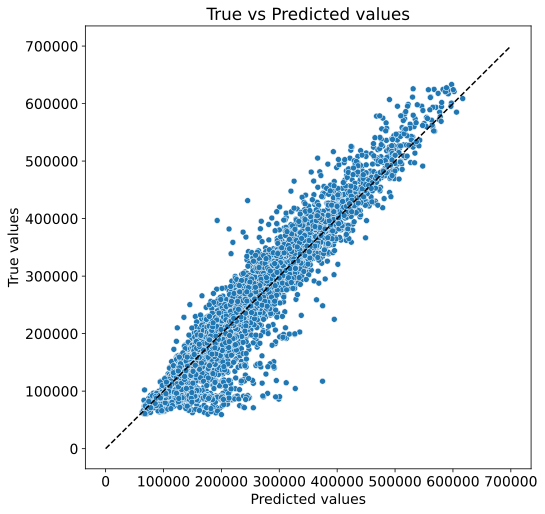

In [342]:
evaluate_preds(y_train, y_train_preds_gb)

In [343]:
y_test_preds_gb = gb_model.predict(test_df_need_feature_names)

### Прогнозирование на тестовом датасете

In [344]:
price = gb_model.predict(test_df_need_feature_names)

In [345]:
price

array([154625.38333872, 235734.69948302, 191482.20163585, ...,
       347414.81880499, 177737.10319667, 175494.93861779])

### Выгрузка резульатов в файл

In [346]:
pd.DataFrame({ 'Id': test_df['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)